### Import Libraries & Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import logging
import warnings
from tensorflow.keras.models import load_model

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import sys
sys.path.append(r'C:\Users\rshaw\Desktop\EC Utbildning - Data Science\Kurs 9 - Project\Project\ds23_projektkurs\predictive-maintenance\src\Data processing scripts')

from CSV_module import CSVReader
from PreProcess_module import PreProcessor
from SQL_module import SQLManager
from sqlalchemy.types import SmallInteger, String, Date, Time

### Load and read data from SQL database

In [155]:
file_urls = [
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_errors.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_failures.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_machines.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_maint.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_telemetry.csv"
]

csv_reader = CSVReader(file_urls, 'csv_reader_log.log')
dataframes = csv_reader.read_csv_files()

cleaned_dataframes = {name: PreProcessor(df).clean_data() for name, df in dataframes.items()}

errors_df = cleaned_dataframes['PdM_errors']
failures_df = cleaned_dataframes['PdM_failures']
machines_df = cleaned_dataframes['PdM_machines']
maint_df = cleaned_dataframes['PdM_maint']
telemetry_df = cleaned_dataframes['PdM_telemetry']

### Basic EDA

In [158]:
telemetry_df.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'date', 'time'], dtype='object')

In [159]:
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['date'].astype(str) + ' ' + telemetry_df['time'].astype(str))
telemetry_df.drop(['date', 'time'], axis=1, inplace=True)

maint_df['datetime'] = pd.to_datetime(maint_df['date'].astype(str) + ' ' + maint_df['time'].astype(str))
maint_df.drop(['date', 'time'], axis=1, inplace=True)

errors_df['datetime'] = pd.to_datetime(errors_df['date'].astype(str) + ' ' + errors_df['time'].astype(str))
errors_df.drop(['date', 'time'], axis=1, inplace=True)

failures_df['datetime'] = pd.to_datetime(failures_df['date'].astype(str) + ' ' + failures_df['time'].astype(str))
failures_df.drop(['date', 'time'], axis=1, inplace=True)


In [160]:
telemetry_df.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'datetime'], dtype='object')

In [161]:
machines_df

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
...,...,...,...
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14


In [162]:
display(telemetry_df['datetime'].min(), telemetry_df['datetime'].max())
display(maint_df['datetime'].min(), maint_df['datetime'].max())
display(errors_df['datetime'].min(), errors_df['datetime'].max())
display(failures_df['datetime'].min(), failures_df['datetime'].max())

Timestamp('2015-01-01 06:00:00')

Timestamp('2016-01-01 06:00:00')

Timestamp('2014-06-01 06:00:00')

Timestamp('2016-01-01 06:00:00')

Timestamp('2015-01-01 06:00:00')

Timestamp('2016-01-01 05:00:00')

Timestamp('2015-01-02 03:00:00')

Timestamp('2015-12-31 06:00:00')

In [163]:
telemetry_df.describe().T

,count,mean,min,25%,50%,75%,max,std
machineID,876100.0,50.5,1.0,25.75,50.5,75.25,100.0,28.866087
volt,876100.0,170.777736,97.333604,160.304927,170.607338,181.004493,255.124717,15.509114
rotate,876100.0,446.605119,138.432075,412.305714,447.55815,482.1766,695.020984,52.673886
pressure,876100.0,100.858668,51.237106,93.498181,100.425559,107.555231,185.951998,11.048679
vibration,876100.0,40.385007,14.877054,36.777299,40.237247,43.784938,76.791072,5.370361
datetime,876100,2015-07-02 18:00:00,2015-01-01 06:00:00,2015-04-02 12:00:00,2015-07-02 18:00:00,2015-10-02 00:00:00,2016-01-01 06:00:00,NaN


- Here we see sensor data for 4 operational settings that occurred over 12 months between January 1, 2015, and January 01, 2016.


In [164]:
print(failures_df.head())
print(failures_df['datetime'].min(), failures_df['datetime'].max())


   machineID failure            datetime
0          1   comp4 2015-01-05 06:00:00
1          1   comp1 2015-03-06 06:00:00
2          1   comp2 2015-04-20 06:00:00
3          1   comp4 2015-06-19 06:00:00
4          1   comp4 2015-09-02 06:00:00
2015-01-02 03:00:00 2015-12-31 06:00:00


- Here we see that failures occurred over 12 months between January 2, 2015, and December 31, 2015. -
- Failures involve different components (comp1, comp2, comp4), all related to machine ID 1 during this time range.

### EDA

In [165]:
#Here we drill down to focus on one machine from 100, namely machine no. 17
df_sel_17 = telemetry_df.loc[telemetry_df['machineID'] == 17].reset_index(drop=True)
print(df_sel_17.head(n=5))

   machineID        volt      rotate    pressure  vibration  \
0         17  161.633747  462.698035   90.377391  49.453414   
1         17  189.976790  372.798586  100.125906  57.482661   
2         17  186.476591  498.922070   97.924391  47.786767   
3         17  167.836488  483.978488  111.113911  66.352721   
4         17  182.431544  502.774702  108.220639  54.571089   

             datetime  
0 2015-01-01 06:00:00  
1 2015-01-01 07:00:00  
2 2015-01-01 08:00:00  
3 2015-01-01 09:00:00  
4 2015-01-01 10:00:00  


In [166]:
df_sel_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   machineID  8761 non-null   int64         
 1   volt       8761 non-null   float64       
 2   rotate     8761 non-null   float64       
 3   pressure   8761 non-null   float64       
 4   vibration  8761 non-null   float64       
 5   datetime   8761 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 410.8 KB


 - This machine number 17 has 8761 rows and 7 columns, including telemetry data (volt, rotate, pressure, vibration) and machineID.
- All columns are numeric except for the datetime column which is a timestamp, and date which is an object type (string).
- Memory used is approx 479.2 KB
- There are no missing values.

In [167]:
print(df_sel_17.columns)


Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'datetime'], dtype='object')


In [168]:
print(df_sel_17[['volt', 'rotate', 'pressure', 'vibration']].describe())

              volt       rotate     pressure    vibration
count  8761.000000  8761.000000  8761.000000  8761.000000
mean    170.726237   445.968525   101.342908    40.549045
std      15.694063    53.034564    11.325382     5.516199
min     107.286569   223.268150    66.079113    20.487291
25%     160.150078   411.696585    93.976460    36.896442
50%     170.503300   446.855943   100.851812    40.320077
75%     181.075973   482.323013   107.945500    43.925871
max     240.105419   637.852152   152.605505    70.587984


- Sensor Ranges: All sensor readings (voltage, rotation, pressure, vibration) show reasonable variability, with voltage and rotation having the highest range of values.

- Relatively Low Variation in Vibration: The vibration sensor has the lowest standard deviation, meaning its values are more tightly clustered around the mean compared to other sensors

In [169]:
machines_with_failures = failures_df['machineID'].unique()
all_machines = telemetry_df['machineID'].unique()  # Alternatively, you can use machines_df['machineID']
machines_without_failures = list(set(all_machines) - set(machines_with_failures))
print(f"Machines with failures: {machines_with_failures}")
print(f"Machines without failures: {machines_without_failures}")

Machines with failures: [  1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100]
Machines without failures: [77, 6]


In [170]:
def histogram_boxplot(df_sel_17, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(
        data=df_sel_17, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )
    sns.histplot(
        data=df_sel_17, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df_sel_17, x=feature, kde=kde, ax=ax_hist2
    )
    ax_hist2.axvline(
        df_sel_17[feature].mean(), color="green", linestyle="--"
    )
    ax_hist2.axvline(
        df_sel_17[feature].median(), color="black", linestyle="-"
    )

Skipping column: machineID
Skipping column: datetime


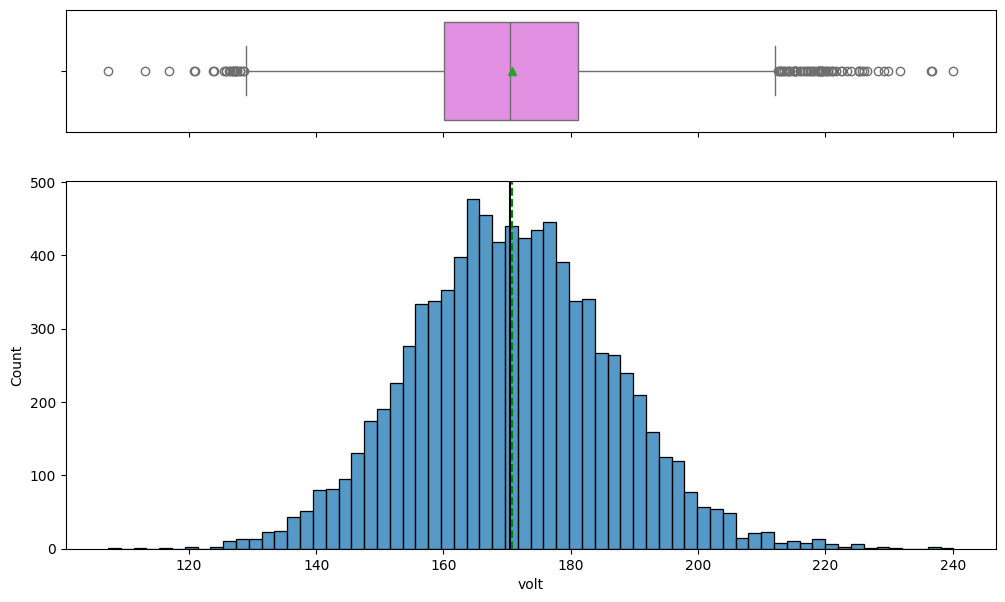

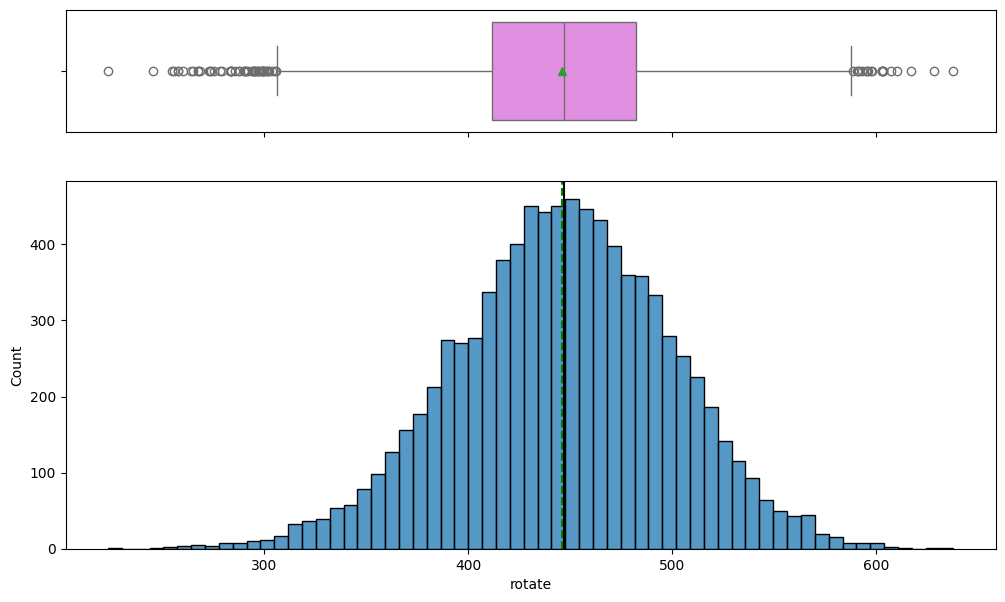

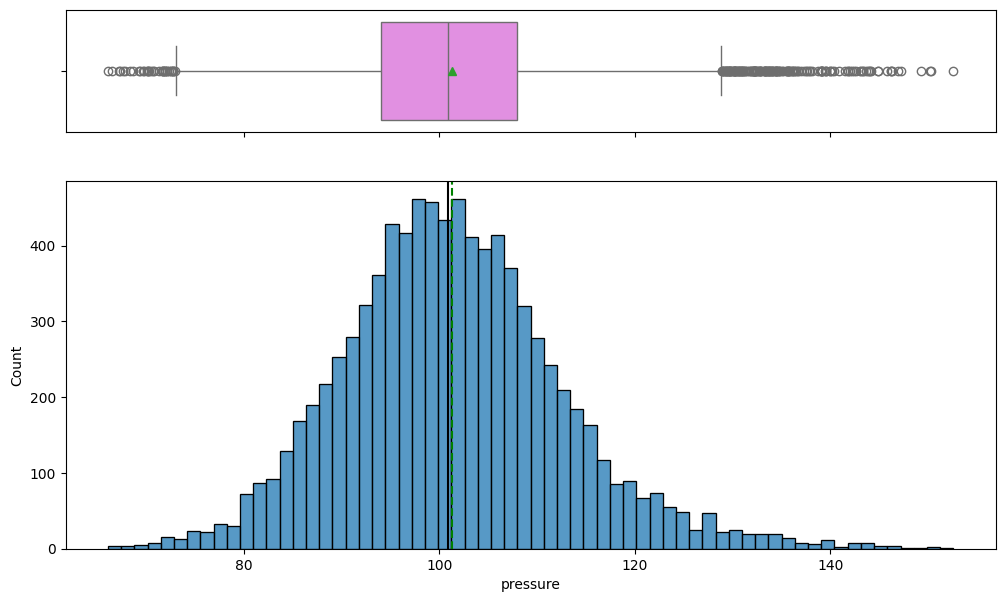

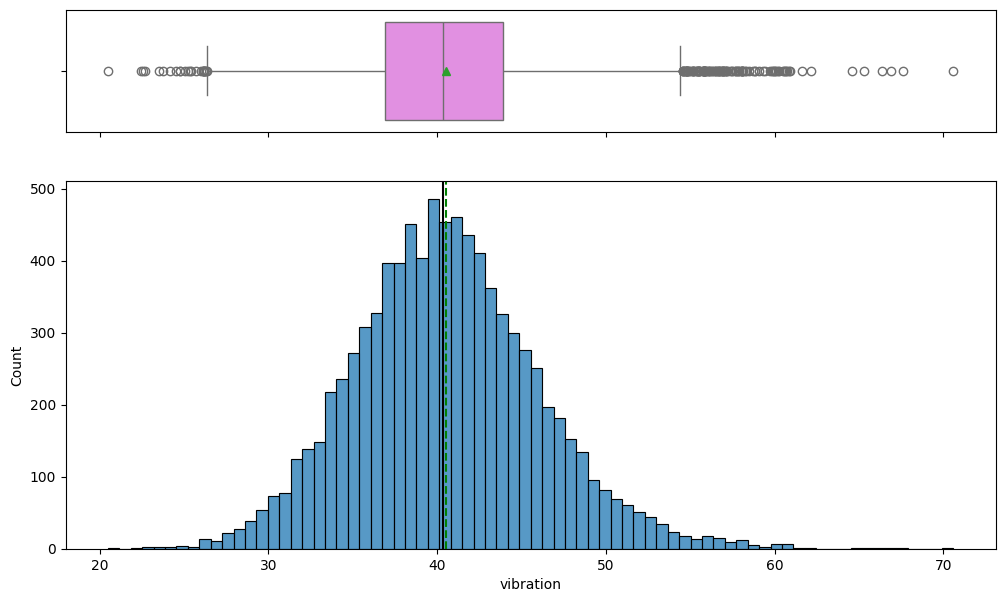

In [171]:
def is_numeric(series):
    return pd.api.types.is_numeric_dtype(series)

for feature in df_sel_17.columns:
    if is_numeric(df_sel_17[feature]) and feature != 'machineID':
        histogram_boxplot(df_sel_17, feature, figsize=(12, 7), kde=False, bins=None)
    else:
        print(f"Skipping column: {feature}")

- Most of the sensors show a fairly normal distribution, with the mean and median values aligning closely.

- Standard Deviation appears to vary across the sensors, with a considerable portion of sensor readings showing spread beyond typical ranges. While some distributions have a higher concentration around the mean, sensors like pressure and voltage show a greater spread with extreme outliers.

- Outliers are present across all four sensors. The voltage and rotation sensors have several outliers on both the lower and upper ends. While these outliers exist, they don't seem to significantly distort the central values (mean and median). The pressure and vibration sensors also show a reasonable number of outliers on the higher end.

- The rotation sensor shows a slight right skew, as shown by a few high-value outliers stretching beyond the bulk of the data. Meanwhile, vibration shows a slight left skew, with more values on the lower side, though it is less pronounced.

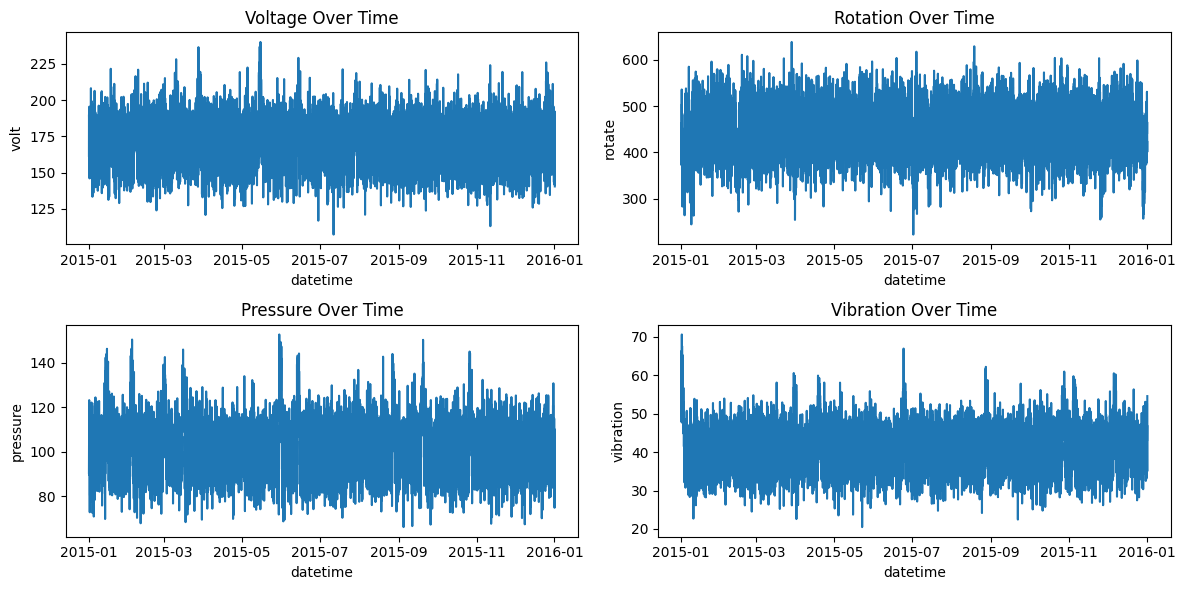

In [172]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.lineplot(x='datetime', y='volt', data=df_sel_17)
plt.title('Voltage Over Time')

plt.subplot(2, 2, 2)
sns.lineplot(x='datetime', y='rotate', data=df_sel_17)
plt.title('Rotation Over Time')

plt.subplot(2, 2, 3)
sns.lineplot(x='datetime', y='pressure', data=df_sel_17)
plt.title('Pressure Over Time')

plt.subplot(2, 2, 4)
sns.lineplot(x='datetime', y='vibration', data=df_sel_17)
plt.title('Vibration Over Time')

plt.tight_layout()
plt.show()

- There seems to be quite a few spikes that could be anomalies leading to errors or failures.
- We'll investigate further using z-scores to see how many standard deviations a sensor data point is from the mean, where we will target any point outside of -3 and +3 as anomaly.

In [173]:
from sklearn.preprocessing import StandardScaler

#Create plots of Z-scores for this machine to check for anomalies over time in sensor data
scaler = StandardScaler()
z_scores = scaler.fit_transform(df_sel_17[['volt', 'rotate', 'pressure', 'vibration']])
z_scores_df = pd.DataFrame(z_scores, columns=['volt_zscore', 'rotate_zscore', 'pressure_zscore', 'vibration_zscore'])
df_anomalies = pd.concat([df_sel_17, z_scores_df], axis=1)
anomalies = df_anomalies[
    (df_anomalies['volt_zscore'].abs() > 3) |
    (df_anomalies['rotate_zscore'].abs() > 3) |
    (df_anomalies['pressure_zscore'].abs() > 3) |
    (df_anomalies['vibration_zscore'].abs() > 3)
]

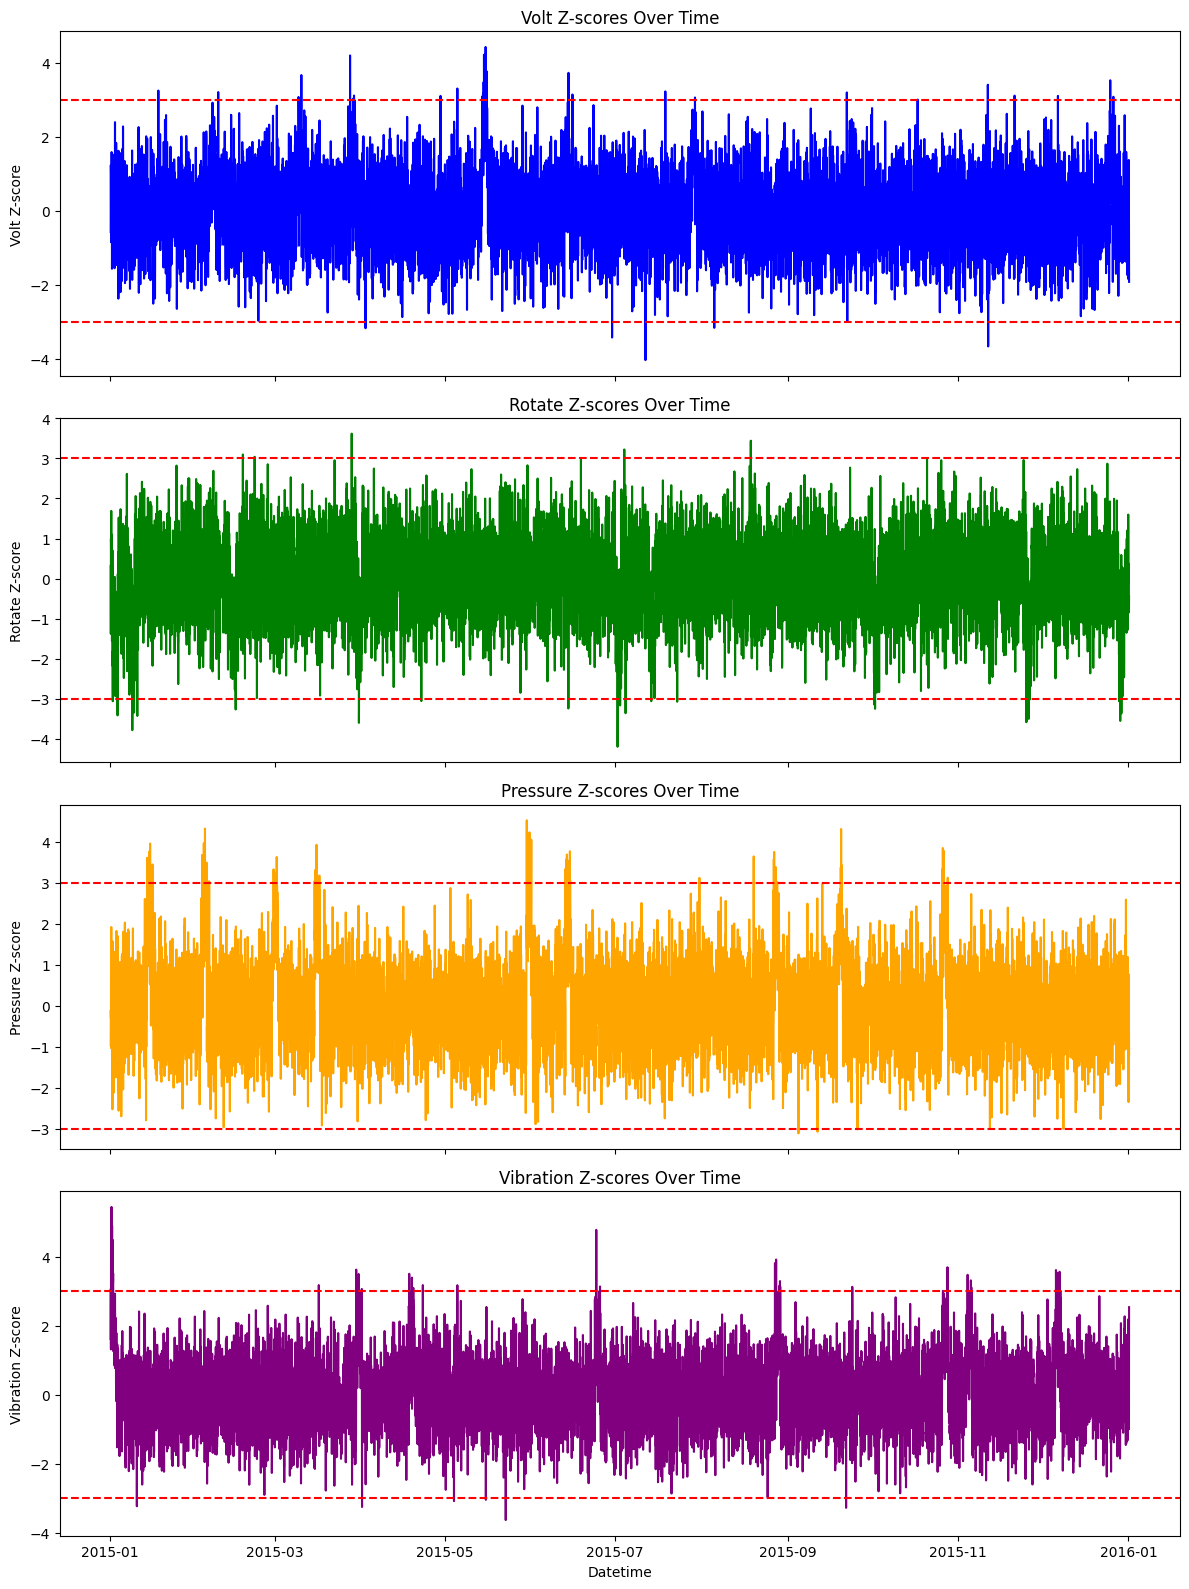

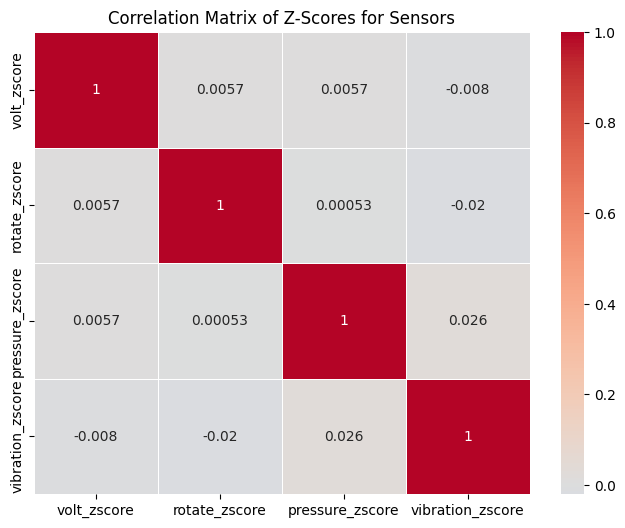

In [174]:
df_anomalies['datetime'] = pd.to_datetime(df_anomalies['datetime'])
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

axs[0].plot(df_anomalies['datetime'], df_anomalies['volt_zscore'], label='Volt Z-score', color='b')
axs[0].set_ylabel('Volt Z-score')
axs[0].axhline(y=3, color='r', linestyle='--')
axs[0].axhline(y=-3, color='r', linestyle='--')
axs[0].set_title('Volt Z-scores Over Time')

axs[1].plot(df_anomalies['datetime'], df_anomalies['rotate_zscore'], label='Rotate Z-score', color='g')
axs[1].set_ylabel('Rotate Z-score')
axs[1].axhline(y=3, color='r', linestyle='--')
axs[1].axhline(y=-3, color='r', linestyle='--')
axs[1].set_title('Rotate Z-scores Over Time')

axs[2].plot(df_anomalies['datetime'], df_anomalies['pressure_zscore'], label='Pressure Z-score', color='orange')
axs[2].set_ylabel('Pressure Z-score')
axs[2].axhline(y=3, color='r', linestyle='--')
axs[2].axhline(y=-3, color='r', linestyle='--')
axs[2].set_title('Pressure Z-scores Over Time')

axs[3].plot(df_anomalies['datetime'], df_anomalies['vibration_zscore'], label='Vibration Z-score', color='purple')
axs[3].set_ylabel('Vibration Z-score')
axs[3].axhline(y=3, color='r', linestyle='--')
axs[3].axhline(y=-3, color='r', linestyle='--')
axs[3].set_title('Vibration Z-scores Over Time')

axs[3].set_xlabel('Datetime')
plt.tight_layout()
plt.show()

correlation_matrix = df_anomalies[['volt_zscore', 'rotate_zscore', 'pressure_zscore', 'vibration_zscore']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Z-Scores for Sensors')
plt.show()

- Both pressure and vibration seem to have more frequent spikes exceeding the threshold, indicating more frequent anomalies.

- The most notable correlation is between the rotate_zscore and vibration_zscore (0.63), meaning these sensors tend to show anomalies at the same time. On the other hand, volt_zscore and pressure_zscore have a moderate negative correlation (-0.60), indicating an inverse relationship.

- These anomalies and correlations give us a good reason to zoom into the time period with most visual peaks during during the first quarter of 2015, to investigate potential patterns, causes, and behavior.

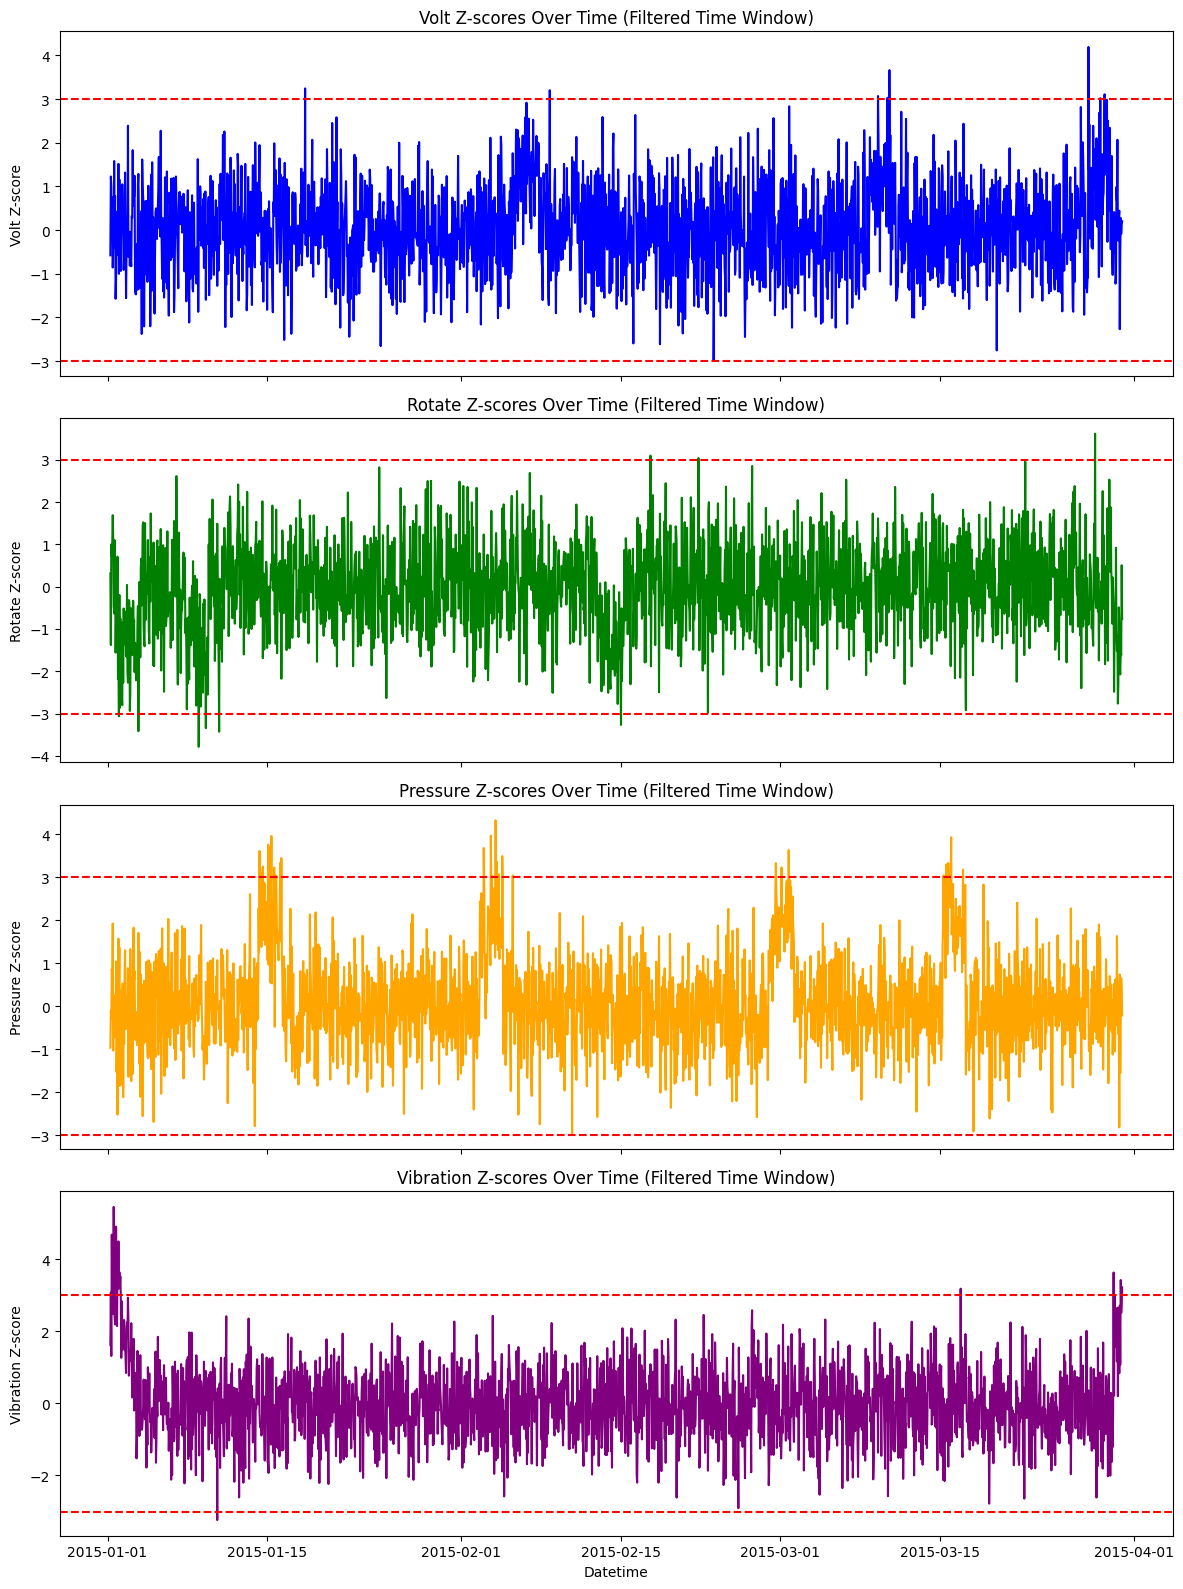

In [175]:
df_anomalies['datetime'] = pd.to_datetime(df_anomalies['datetime'])
start_date = '2015-01-01'
end_date = '2015-03-31'
df_time_window = df_anomalies[(df_anomalies['datetime'] >= start_date) & (df_anomalies['datetime'] <= end_date)]
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

axs[0].plot(df_time_window['datetime'], df_time_window['volt_zscore'], label='Volt Z-score', color='b')
axs[0].set_ylabel('Volt Z-score')
axs[0].axhline(y=3, color='r', linestyle='--')
axs[0].axhline(y=-3, color='r', linestyle='--')
axs[0].set_title('Volt Z-scores Over Time (Filtered Time Window)')

axs[1].plot(df_time_window['datetime'], df_time_window['rotate_zscore'], label='Rotate Z-score', color='g')
axs[1].set_ylabel('Rotate Z-score')
axs[1].axhline(y=3, color='r', linestyle='--')
axs[1].axhline(y=-3, color='r', linestyle='--')
axs[1].set_title('Rotate Z-scores Over Time (Filtered Time Window)')

axs[2].plot(df_time_window['datetime'], df_time_window['pressure_zscore'], label='Pressure Z-score', color='orange')
axs[2].set_ylabel('Pressure Z-score')
axs[2].axhline(y=3, color='r', linestyle='--')
axs[2].axhline(y=-3, color='r', linestyle='--')
axs[2].set_title('Pressure Z-scores Over Time (Filtered Time Window)')

axs[3].plot(df_time_window['datetime'], df_time_window['vibration_zscore'], label='Vibration Z-score', color='purple')
axs[3].set_ylabel('Vibration Z-score')
axs[3].axhline(y=3, color='r', linestyle='--')
axs[3].axhline(y=-3, color='r', linestyle='--')
axs[3].set_title('Vibration Z-scores Over Time (Filtered Time Window)')

axs[3].set_xlabel('Datetime')
plt.tight_layout()
plt.show()


Overall, this first-quarter analysis highlights significant fluctuations, especially in voltage, pressure, and vibration, with several data points indicating potential anomalies or outliers. These might correlate with system irregularities or potential failures if left unchecked.

### Data Preprocessing (in addition to Missis scripts)

In [176]:
#Here we create dummies for model
machines_df = pd.get_dummies(machines_df, columns=['model'], prefix='', prefix_sep='')
machines_df

,machineID,age,model1,model2,model3,model4
0,1,18,False,False,True,False
1,2,7,False,False,False,True
2,3,8,False,False,True,False
3,4,7,False,False,True,False
4,5,2,False,False,True,False
...,...,...,...,...,...,...
95,96,10,False,True,False,False
96,97,14,False,True,False,False
97,98,20,False,True,False,False
98,99,14,True,False,False,False


In [177]:
errors_df.rename(columns={'datetime': 'datetime_error'}, inplace=True)
failures_df.rename(columns={'datetime': 'datetime_failure'}, inplace=True)
maint_df.rename(columns={'datetime': 'datetime_maint'}, inplace=True)
telemetry_df.rename(columns={'datetime': 'datetime_telemetry'}, inplace=True)

errors_df['datetime_error'] = pd.to_datetime(errors_df['datetime_error'])
failures_df['datetime_failure'] = pd.to_datetime(failures_df['datetime_failure'])
maint_df['datetime_maint'] = pd.to_datetime(maint_df['datetime_maint'])
telemetry_df['datetime_telemetry'] = pd.to_datetime(telemetry_df['datetime_telemetry'])

print(errors_df['datetime_error'].dtypes)
print(failures_df['datetime_failure'].dtypes)
print(maint_df['datetime_maint'].dtypes)
print(telemetry_df['datetime_telemetry'].dtypes)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [178]:
# Create failure, error and maintenance flags to prep for feature engineering
failures_df['failure_flag'] = 1
failure_count = failures_df['failure_flag'].sum()

errors_df['error_flag'] = 1
error_count = errors_df['error_flag'].sum()

maint_df['maint_flag'] = 1
maintenance_count = maint_df['maint_flag'].sum()

print(f"Number of failures: {failure_count}")
print(f"Number of errors: {error_count}")
print(f"Number of maintenances: {maintenance_count}")

Number of failures: 761
Number of errors: 3919
Number of maintenances: 3286


In [179]:
maint_df.head()

,machineID,comp,datetime_maint,maint_flag
0,1,comp2,2014-06-01 06:00:00,1
1,1,comp4,2014-07-16 06:00:00,1
2,1,comp3,2014-07-31 06:00:00,1
3,1,comp1,2014-12-13 06:00:00,1
4,1,comp4,2015-01-05 06:00:00,1


In [180]:
print(telemetry_df.shape)
print(errors_df.shape)
print(failures_df.shape)
print(maint_df.shape)
print(machines_df.shape)

(876100, 6)
(3919, 4)
(761, 4)
(3286, 4)
(100, 6)


In [181]:
display(telemetry_df.head())
display(errors_df.head())
display(failures_df.head())
display(maint_df.head())
display(machines_df.head())

,machineID,volt,rotate,pressure,vibration,datetime_telemetry
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00
1,1,162.879223,402.747490,95.460525,43.413973,2015-01-01 07:00:00
2,1,170.989902,527.349825,75.237905,34.178847,2015-01-01 08:00:00
3,1,162.462833,346.149335,109.248561,41.122144,2015-01-01 09:00:00
4,1,157.610021,435.376873,111.886648,25.990511,2015-01-01 10:00:00


,machineID,errorID,datetime_error,error_flag
0,1,error1,2015-01-03 07:00:00,1
1,1,error3,2015-01-03 20:00:00,1
2,1,error5,2015-01-04 06:00:00,1
3,1,error4,2015-01-10 15:00:00,1
4,1,error4,2015-01-22 10:00:00,1


,machineID,failure,datetime_failure,failure_flag
0,1,comp4,2015-01-05 06:00:00,1
1,1,comp1,2015-03-06 06:00:00,1
2,1,comp2,2015-04-20 06:00:00,1
3,1,comp4,2015-06-19 06:00:00,1
4,1,comp4,2015-09-02 06:00:00,1


,machineID,comp,datetime_maint,maint_flag
0,1,comp2,2014-06-01 06:00:00,1
1,1,comp4,2014-07-16 06:00:00,1
2,1,comp3,2014-07-31 06:00:00,1
3,1,comp1,2014-12-13 06:00:00,1
4,1,comp4,2015-01-05 06:00:00,1


,machineID,age,model1,model2,model3,model4
0,1,18,False,False,True,False
1,2,7,False,False,False,True
2,3,8,False,False,True,False
3,4,7,False,False,True,False
4,5,2,False,False,True,False


In [182]:
print(telemetry_df.columns)
print(failures_df.columns)
print(errors_df.columns)
print(maint_df.columns)


Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'datetime_telemetry'],
      dtype='object')
Index(['machineID', 'failure', 'datetime_failure', 'failure_flag'], dtype='object')
Index(['machineID', 'errorID', 'datetime_error', 'error_flag'], dtype='object')
Index(['machineID', 'comp', 'datetime_maint', 'maint_flag'], dtype='object')


In [183]:
##### Merge Data before feature engineering
telemetry_df = telemetry_df.sort_values('datetime_telemetry')
failures_df = failures_df.sort_values('datetime_failure')
errors_df = errors_df.sort_values('datetime_error')
maintenance_df = maint_df.sort_values('datetime_maint')

merged_df = pd.merge_asof(
    telemetry_df,
    failures_df[['machineID', 'datetime_failure', 'failure_flag']],
    by='machineID',
    left_on='datetime_telemetry',
    right_on='datetime_failure',
    direction='backward',
    tolerance=pd.Timedelta('12h')
)

merged_df = pd.merge_asof(
    merged_df,
    errors_df[['machineID', 'datetime_error', 'error_flag']],
    by='machineID',
    left_on='datetime_telemetry',
    right_on='datetime_error',
    direction='backward',
    tolerance=pd.Timedelta('12h')
)

merged_df = pd.merge_asof(
    merged_df,
    maintenance_df[['machineID', 'datetime_maint', 'maint_flag']],
    by='machineID',
    left_on='datetime_telemetry',
    right_on='datetime_maint',
    direction='backward',
    tolerance=pd.Timedelta('14d')
)

merged_df = pd.merge(
    merged_df,
    machines_df,  # Exclude 'model' as it has been replaced by dummies
    on='machineID',
    how='left'
)

indicator_columns = ['failure_flag', 'error_flag', 'maint_flag']

# Fill NaN values with 0 for each indicator column and convert to integer type
merged_df.fillna({col: 0 for col in indicator_columns}, inplace=True)

for col in indicator_columns:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].astype(int)

display(merged_df)

,machineID,volt,rotate,pressure,vibration,datetime_telemetry,datetime_failure,failure_flag,datetime_error,error_flag,datetime_maint,maint_flag,age,model1,model2,model3,model4
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,NaT,0,NaT,0,NaT,0,18,False,False,True,False
1,53,183.084582,420.980061,109.235805,45.737760,2015-01-01 06:00:00,NaT,0,NaT,0,NaT,0,5,False,False,True,False
2,99,168.596133,384.747105,110.921131,41.944692,2015-01-01 06:00:00,NaT,0,NaT,0,2014-12-28 06:00:00,1,14,True,False,False,False
3,12,171.404215,576.923563,97.145400,47.725909,2015-01-01 06:00:00,NaT,0,NaT,0,NaT,0,9,False,False,True,False
4,6,136.878588,492.088420,149.003582,22.973289,2015-01-01 06:00:00,NaT,0,NaT,0,2014-12-28 06:00:00,1,7,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,70,188.135372,457.661580,89.725251,42.932201,2016-01-01 06:00:00,NaT,0,NaT,0,2015-12-24 06:00:00,1,9,False,False,True,False
876096,71,174.028202,349.326013,111.231561,38.669674,2016-01-01 06:00:00,NaT,0,NaT,0,2015-12-22 06:00:00,1,18,False,True,False,False
876097,72,183.176861,381.242172,104.658441,38.504998,2016-01-01 06:00:00,NaT,0,NaT,0,2015-12-19 06:00:00,1,2,False,False,False,True
876098,74,188.299688,494.616310,101.785150,41.609665,2016-01-01 06:00:00,NaT,0,NaT,0,2015-12-19 06:00:00,1,4,False,False,False,True


In [184]:
print(merged_df.isnull().sum())

machineID                  0
volt                       0
rotate                     0
pressure                   0
vibration                  0
datetime_telemetry         0
datetime_failure      866763
failure_flag               0
datetime_error        830260
error_flag                 0
datetime_maint        162090
maint_flag                 0
age                        0
model1                     0
model2                     0
model3                     0
model4                     0
dtype: int64


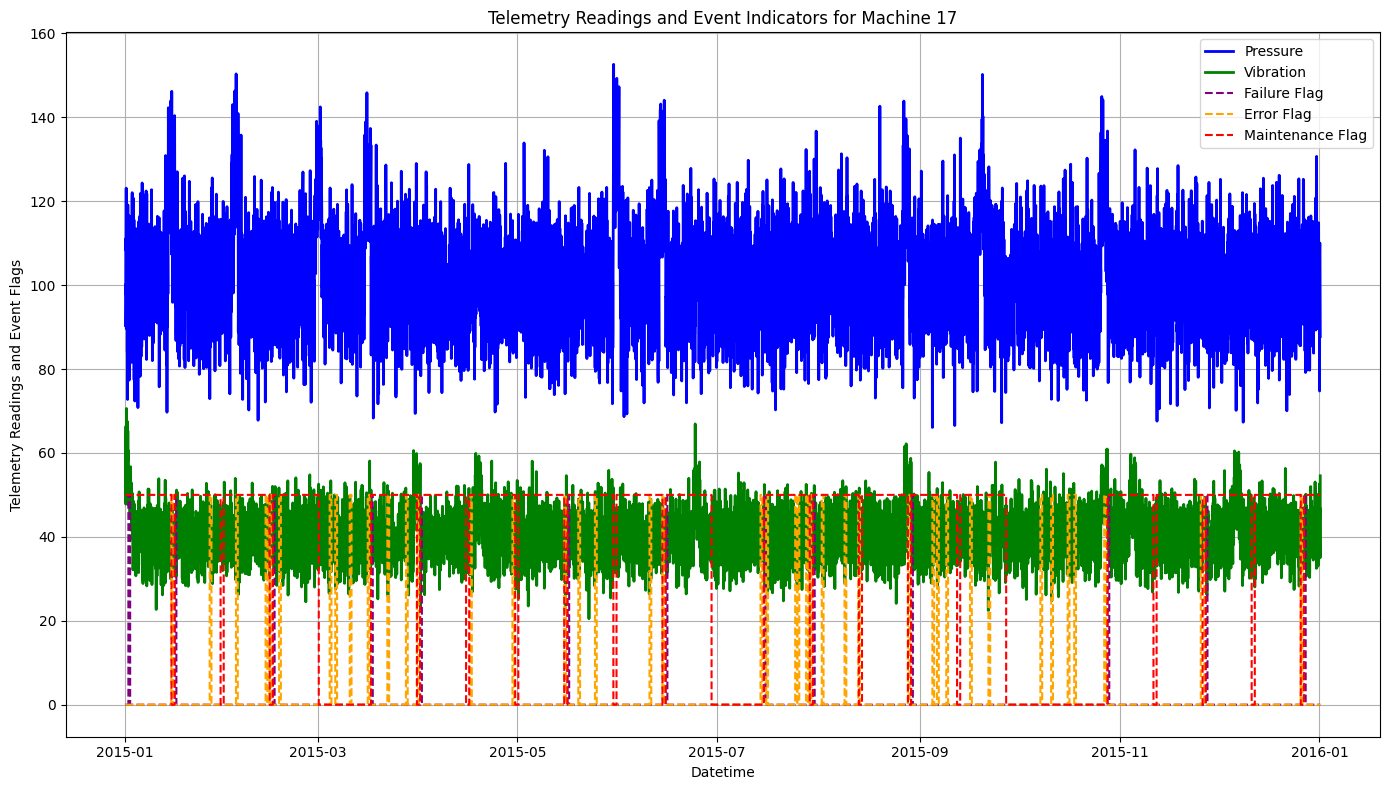

In [185]:
machine_id_to_plot = 17
plot_df = merged_df[merged_df['machineID'] == machine_id_to_plot]

plt.figure(figsize=(14, 8))
plt.plot(plot_df['datetime_telemetry'], plot_df['pressure'], label='Pressure', color='blue', linewidth=2)
plt.plot(plot_df['datetime_telemetry'], plot_df['vibration'], label='Vibration', color='green', linewidth=2)
if 'failure_flag' in plot_df.columns:
    plt.step(plot_df['datetime_telemetry'], plot_df['failure_flag'] * 50, label='Failure Flag', color='purple', linestyle='--', where='post')
if 'error_flag' in plot_df.columns:
    plt.step(plot_df['datetime_telemetry'], plot_df['error_flag'] * 50, label='Error Flag', color='orange', linestyle='--', where='post')
if 'maint_flag' in plot_df.columns:
    plt.step(plot_df['datetime_telemetry'], plot_df['maint_flag'] * 50, label='Maintenance Flag', color='red', linestyle='--', where='post')
plt.xlabel('Datetime')
plt.ylabel('Telemetry Readings and Event Flags')
plt.title(f'Telemetry Readings and Event Indicators for Machine {machine_id_to_plot}')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

- While for only 1 machine, this still shows a trend of reactive mainteance until the last quarter of 2015 and then a major uturn in proactive maintenace at the end of the year.
- Errors are consistent and can lead to failures but the correlation isn't clear.

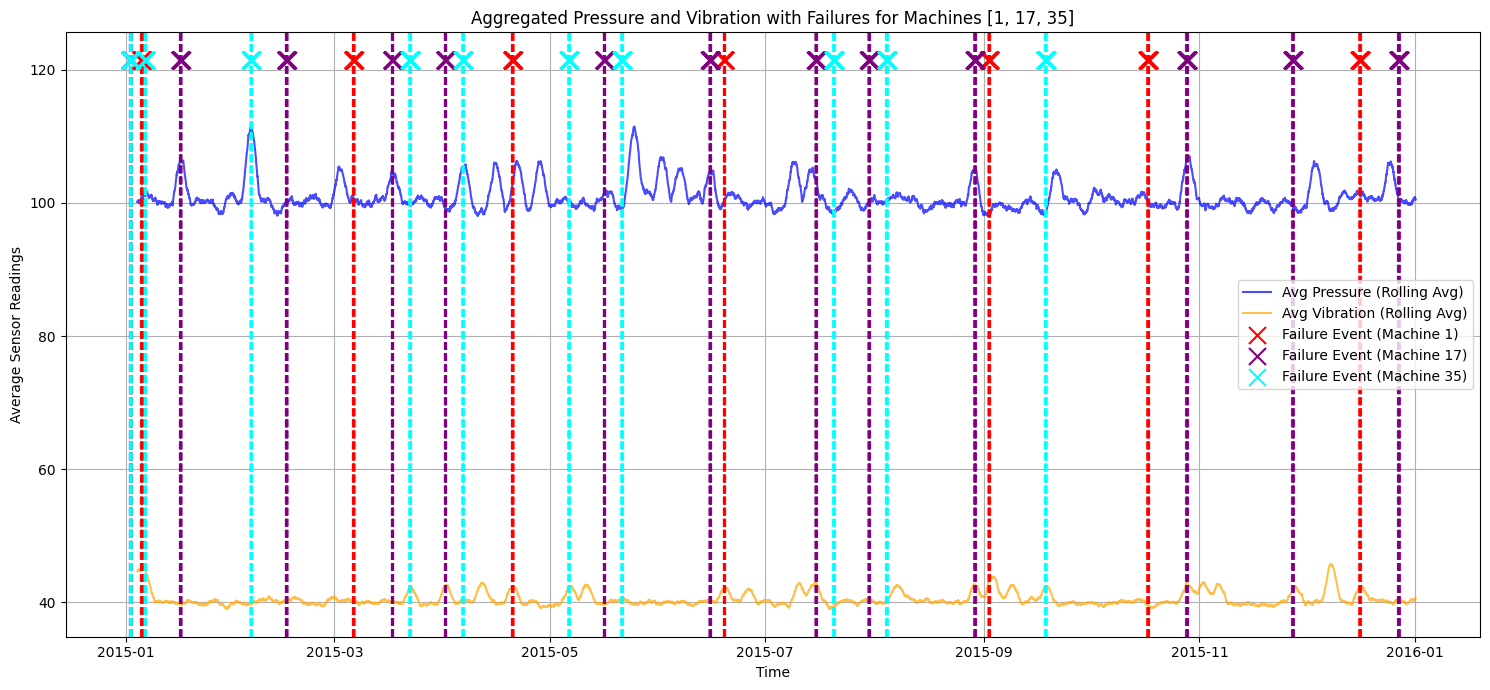

In [186]:
# Closer look at pressure and vibration link to failure
selected_machine_ids = [1, 17, 35]
window_size = 72

pressure_agg = merged_df[merged_df['machineID'].isin(selected_machine_ids)].groupby('datetime_telemetry')['pressure'].mean().rolling(window=window_size).mean()
vibration_agg = merged_df[merged_df['machineID'].isin(selected_machine_ids)].groupby('datetime_telemetry')['vibration'].mean().rolling(window=window_size).mean()

failure_colors = {1: 'red', 17: 'purple', 35: 'cyan'}

plt.figure(figsize=(15, 7))

plt.plot(pressure_agg.index, pressure_agg, label='Avg Pressure (Rolling Avg)', color='blue', alpha=0.7)
plt.plot(vibration_agg.index, vibration_agg, label='Avg Vibration (Rolling Avg)', color='orange', alpha=0.7)

for machine_id, color, label in zip([1, 17, 35], ['red', 'purple', 'cyan'],
                                    ['Failure Event (Machine 1)', 'Failure Event (Machine 17)', 'Failure Event (Machine 35)']):
    failure_times = merged_df[(merged_df['machineID'] == machine_id) & (merged_df['failure_flag'] == 1)]['datetime_telemetry']

    plt.scatter(failure_times, [pressure_agg.max() + 10] * len(failure_times), color=color, marker='x', label=label, s=150, zorder=5)

    for ft in failure_times:
        plt.axvline(x=ft, color=color, linestyle='--', alpha=0.5)

# Finalize plot
plt.xlabel('Time')
plt.ylabel('Average Sensor Readings')
plt.title('Aggregated Pressure and Vibration with Failures for Machines [1, 17, 35]')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Feature Engineering

In [187]:
merged_df.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'datetime_telemetry', 'datetime_failure', 'failure_flag',
       'datetime_error', 'error_flag', 'datetime_maint', 'maint_flag', 'age',
       'model1', 'model2', 'model3', 'model4'],
      dtype='object')

In [188]:
# Calculate datetime of next failure for each row where failure_indicator is 1
merged_df['datetime_failure'] = merged_df['datetime_telemetry'].where(merged_df['failure_flag'] == 1)
merged_df['datetime_failure'] = merged_df.groupby('machineID')['datetime_failure'].bfill()

# Calculate RUL as the time difference in hours
merged_df['RUL'] = (merged_df['datetime_failure'] - merged_df['datetime_telemetry']).dt.total_seconds() / 3600

# Calculate mean RUL per machine
machine_rul_means = merged_df.groupby('machineID')['RUL'].mean().to_dict()

# Adjust NaN RULs for each machine using mean values
for machine_id, mean_rul in machine_rul_means.items():
    machine_data = merged_df[merged_df['machineID'] == machine_id].copy()

    # Find the index of the last known failure for this machine
    last_fail_index = machine_data[machine_data['failure_flag'] == 1].index.max()

    if pd.isna(last_fail_index):
        print(f"No failures found for machineID {machine_id}, using average RUL for adjustments.")
        # Use the mean RUL for the entire machine if no failure is present
        mean_value = mean_rul
        initial_mean_value = mean_value
        nan_indices = machine_data.index

        for index in nan_indices:
            merged_df.loc[index, 'RUL'] = max(mean_value, 0)
            mean_value -= 1
            if mean_value < 0:
                mean_value = initial_mean_value
    else:
        # Use mean RUL for NaN values after the last failure
        mean_value = mean_rul
        initial_mean_value = mean_value
        nan_indices_after_failure = machine_data.loc[last_fail_index + 1:, 'RUL'].index

        for index in nan_indices_after_failure:
            merged_df.loc[index, 'RUL'] = max(mean_value, 0)
            mean_value -= 1
            if mean_value < 0:
                mean_value = initial_mean_value

# Handle machines similar to machine 77
# Find similar machines (age 10-15 years and model 4)
model4_machines_like_77 = merged_df[(merged_df['model4'] == 1) & (merged_df['age'] >= 10) & (merged_df['age'] <= 15)]
model4_machines_like_77_list = model4_machines_like_77['machineID']
model4_machines_like_77_data = merged_df[merged_df['machineID'].isin(model4_machines_like_77_list)]
model4_machines_like_77_data = model4_machines_like_77_data.dropna(subset=['RUL'])
mean_rul_model4_like_77 = model4_machines_like_77_data['RUL'].mean()

# Apply the calculated average RUL to machine 77 and count down
machine_data_77 = merged_df[merged_df['machineID'] == 77].copy()
mean_value_77 = mean_rul_model4_like_77
initial_mean_value_77 = mean_value_77

nan_indices_after_failure_77 = machine_data_77.index[machine_data_77['RUL'].isna()]

for index in nan_indices_after_failure_77:
    merged_df.loc[index, 'RUL'] = max(mean_value_77, 0)
    mean_value_77 -= 1
    if mean_value_77 < 0:
        mean_value_77 = initial_mean_value_77

# Handle machines similar to machine 6
# Find similar machines (age 7 and model 3)
machine_like_6 = merged_df[(merged_df['model3'] == 1) & (merged_df['age'] == 7)]['machineID']
machine_like_6_data = merged_df[merged_df['machineID'].isin(machine_like_6)]
mean_rul_machine_like_6 = machine_like_6_data['RUL'].mean()

# Apply the calculated average RUL to machine 6 and count down
machine_data_6 = merged_df[merged_df['machineID'] == 6].copy()
mean_value_6 = mean_rul_machine_like_6
initial_mean_value_6 = mean_value_6

nan_indices_6 = machine_data_6.index[machine_data_6['RUL'].isna()]

for index in nan_indices_6:
    merged_df.loc[index, 'RUL'] = max(mean_value_6, 0)
    mean_value_6 -= 1
    if mean_value_6 < 0:
        mean_value_6 = initial_mean_value_6

No failures found for machineID 6, using average RUL for adjustments.
No failures found for machineID 77, using average RUL for adjustments.


In [189]:
merged_df.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'datetime_telemetry', 'datetime_failure', 'failure_flag',
       'datetime_error', 'error_flag', 'datetime_maint', 'maint_flag', 'age',
       'model1', 'model2', 'model3', 'model4', 'RUL'],
      dtype='object')

In [190]:
# Check for Missing RUL Values
missing_rul_count = merged_df['RUL'].isna().sum()
if missing_rul_count == 0:
    print("All RUL values have been assigned correctly.")
else:
    print(f"There are {missing_rul_count} missing RUL values.")

# Investigate Machines with Missing RULs
missing_rul_machines = merged_df[merged_df['RUL'].isna()]['machineID'].unique()
print(f"Machines with missing RUL values: {missing_rul_machines[:10]} (showing first 10)")

All RUL values have been assigned correctly.
Machines with missing RUL values: [] (showing first 10)


In [191]:
display(merged_df['RUL'].isna().sum())
display(merged_df.shape[1])

0

18

In [192]:
# Verify the Countdown Logic for Machine 1
machine_1_rul = merged_df[merged_df['machineID'] == 1][['datetime_telemetry', 'RUL']]
print(machine_1_rul.head(20))
rul_min = machine_1_rul['RUL'].min()
if rul_min >= 0:
    print(f"RUL countdown works correctly for machine 1, with minimum value {rul_min}.")
else:
    print("RUL countdown error: RUL reached below 0.")

# Validate RUL for Machine 6 and Machine 77
machine_6_rul = merged_df[merged_df['machineID'] == 6][['datetime_telemetry', 'RUL']]
print("Machine 6 RUL:")
print(machine_6_rul.head())

machine_77_rul = merged_df[merged_df['machineID'] == 77][['datetime_telemetry', 'RUL']]
print("Machine 77 RUL:")
print(machine_77_rul.head())

print(merged_df[['machineID', 'datetime_telemetry', 'RUL']].head(10))


      datetime_telemetry   RUL
0    2015-01-01 06:00:00  96.0
168  2015-01-01 07:00:00  95.0
241  2015-01-01 08:00:00  94.0
398  2015-01-01 09:00:00  93.0
419  2015-01-01 10:00:00  92.0
527  2015-01-01 11:00:00  91.0
627  2015-01-01 12:00:00  90.0
773  2015-01-01 13:00:00  89.0
870  2015-01-01 14:00:00  88.0
958  2015-01-01 15:00:00  87.0
1037 2015-01-01 16:00:00  86.0
1191 2015-01-01 17:00:00  85.0
1290 2015-01-01 18:00:00  84.0
1384 2015-01-01 19:00:00  83.0
1468 2015-01-01 20:00:00  82.0
1503 2015-01-01 21:00:00  81.0
1604 2015-01-01 22:00:00  80.0
1729 2015-01-01 23:00:00  79.0
1874 2015-01-02 00:00:00  78.0
1934 2015-01-02 01:00:00  77.0
RUL countdown works correctly for machine 1, with minimum value 0.0.
Machine 6 RUL:
     datetime_telemetry        RUL
4   2015-01-01 06:00:00  680.07757
111 2015-01-01 07:00:00  679.07757
289 2015-01-01 08:00:00  678.07757
374 2015-01-01 09:00:00  677.07757
498 2015-01-01 10:00:00  676.07757
Machine 77 RUL:
     datetime_telemetry          RUL
73

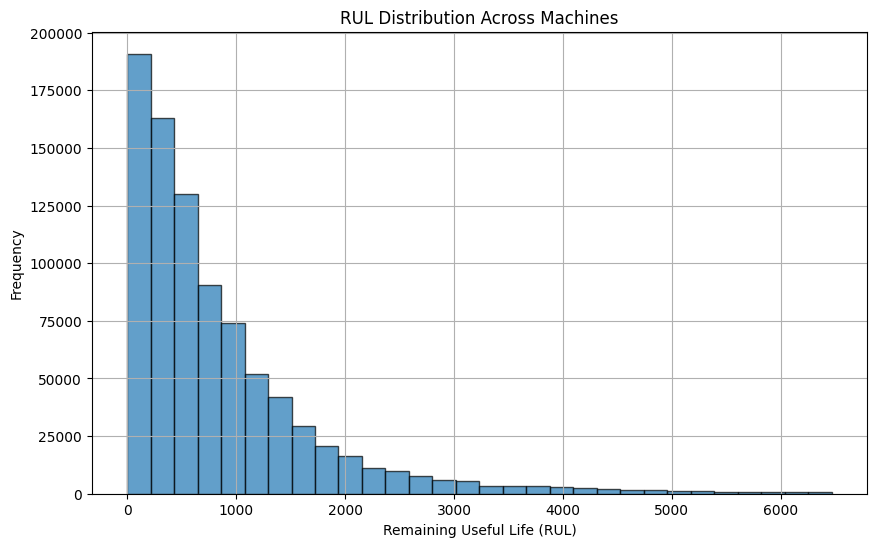

In [193]:
if 'RUL' in merged_df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(merged_df['RUL'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('RUL Distribution Across Machines')
    plt.xlabel('Remaining Useful Life (RUL)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("The RUL column is missing in the merged_df DataFrame.")


In [194]:
#1 Check RUL values after failure timestamps (should be 0)
df_after_failure = merged_df[merged_df['failure_flag'] == 1]

# Check if any RUL is greater than 0 after failure
incorrect_rul_after_failure = df_after_failure[df_after_failure['RUL'] > 0]

if not incorrect_rul_after_failure.empty:
    print("RUL values after failure that are not 0:")
    display(incorrect_rul_after_failure[['machineID', 'datetime_telemetry', 'failure_flag', 'RUL']])
else:
    print("All RUL values after failure are 0.")


All RUL values after failure are 0.


In [195]:
# Filter rows where failure has not occurred yet (failure_flag == 0)
df_before_failure = merged_df[merged_df['failure_flag'] == 0]
df_before_failure = df_before_failure.sort_values(by=['machineID', 'datetime_telemetry'])

# Calculate the RUL difference for each machine (to check if RUL is decreasing)
df_before_failure['RUL_diff'] = df_before_failure.groupby('machineID')['RUL'].diff()
incorrect_rul_before_failure = df_before_failure[df_before_failure['RUL_diff'] < 0]

# Show rows where RUL is increasing (which shouldn't happen)
if incorrect_rul_before_failure.empty:
    print("RUL values before failure that are not decreasing:")
    display(incorrect_rul_before_failure[['machineID', 'datetime_telemetry', 'RUL', 'RUL_diff']])
else:
    print("All RUL values before failure are decreasing correctly.")

display(merged_df.shape[1])

All RUL values before failure are decreasing correctly.


18

In [196]:
maint_df

,machineID,comp,datetime_maint,maint_flag
0,1,comp2,2014-06-01 06:00:00,1
1,1,comp4,2014-07-16 06:00:00,1
2,1,comp3,2014-07-31 06:00:00,1
3,1,comp1,2014-12-13 06:00:00,1
4,1,comp4,2015-01-05 06:00:00,1
...,...,...,...,...
3281,100,comp3,2015-10-10 06:00:00,1
3282,100,comp4,2015-10-25 06:00:00,1
3283,100,comp4,2015-11-09 06:00:00,1
3284,100,comp2,2015-12-09 06:00:00,1


In [197]:
merged_df.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'datetime_telemetry', 'datetime_failure', 'failure_flag',
       'datetime_error', 'error_flag', 'datetime_maint', 'maint_flag', 'age',
       'model1', 'model2', 'model3', 'model4', 'RUL'],
      dtype='object')

In [198]:
#time since last maintenance
telemetry_df['datetime_telemetry'] = pd.to_datetime(telemetry_df['datetime_telemetry'], errors='coerce')
maint_df['datetime_maint'] = pd.to_datetime(maint_df['datetime_maint'], errors='coerce')

merged_with_maint = pd.merge_asof(
    telemetry_df.sort_values('datetime_telemetry'),
    maint_df.sort_values('datetime_maint'),
    by='machineID',
    left_on='datetime_telemetry',
    right_on='datetime_maint',
    direction='backward',
    allow_exact_matches=False
)

merged_with_maint['time_since_last_maint'] = (
    (merged_with_maint['datetime_telemetry'] - merged_with_maint['datetime_maint']).dt.total_seconds() / 3600
)
merged_with_maint['time_since_last_maint'] = merged_with_maint['time_since_last_maint'].fillna(99999)

merged_df = pd.merge(
    merged_df,
    merged_with_maint[['machineID', 'datetime_telemetry', 'time_since_last_maint']],
    on=['machineID', 'datetime_telemetry'],
    how='left'
)

print("Columns in the final merged DataFrame:")
print(merged_df.columns)

Columns in the final merged DataFrame:
Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'datetime_telemetry', 'datetime_failure', 'failure_flag',
       'datetime_error', 'error_flag', 'datetime_maint', 'maint_flag', 'age',
       'model1', 'model2', 'model3', 'model4', 'RUL', 'time_since_last_maint'],
      dtype='object')


'Sample machine time_since_last_maint check:'

,datetime_telemetry,maint_flag,datetime_maint,time_since_last_maint
90,2015-01-01 06:00:00,1,2015-01-01 06:00:00,816.0
125,2015-01-01 07:00:00,1,2015-01-01 06:00:00,1.0
293,2015-01-01 08:00:00,1,2015-01-01 06:00:00,2.0
370,2015-01-01 09:00:00,1,2015-01-01 06:00:00,3.0
486,2015-01-01 10:00:00,1,2015-01-01 06:00:00,4.0
...,...,...,...,...
875635,2016-01-01 02:00:00,1,2015-12-27 06:00:00,116.0
875745,2016-01-01 03:00:00,1,2015-12-27 06:00:00,117.0
875836,2016-01-01 04:00:00,1,2015-12-27 06:00:00,118.0
875992,2016-01-01 05:00:00,1,2015-12-27 06:00:00,119.0


'\nRows with no maintenance history:'

,machineID,datetime_telemetry,time_since_last_maint


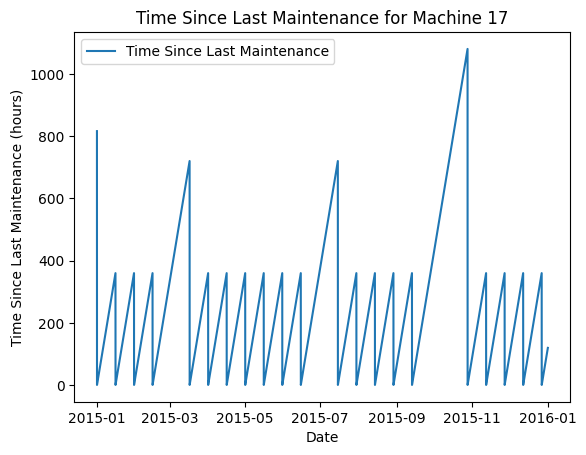

In [199]:
merged_df['datetime_telemetry'] = pd.to_datetime(merged_df['datetime_telemetry'], errors='coerce')
merged_df['datetime_maint'] = pd.to_datetime(merged_df['datetime_maint'], errors='coerce')

sample_machine_id = 17
sample_machine = merged_df[merged_df['machineID'] == sample_machine_id].sort_values('datetime_telemetry')
display("Sample machine time_since_last_maint check:")
display(sample_machine[['datetime_telemetry', 'maint_flag', 'datetime_maint', 'time_since_last_maint']])

# Check that rows with no maintenance history are correctly filled with 99999
no_maint_history = merged_df[(merged_df['maint_flag'] == 0) & (merged_df['time_since_last_maint'] == 99999)]
display("\nRows with no maintenance history:")
display(no_maint_history[['machineID', 'datetime_telemetry', 'time_since_last_maint']].head())

plt.plot(sample_machine['datetime_telemetry'], sample_machine['time_since_last_maint'], label='Time Since Last Maintenance')
plt.xlabel('Date')
plt.ylabel('Time Since Last Maintenance (hours)')
plt.title(f'Time Since Last Maintenance for Machine {sample_machine_id}')
plt.legend()
plt.show()

- Cyclic Behavior: The graph reflects cyclic maintenance behavior, where maintenance is consistently performed after varying periods.
- Longer Gaps: The higher peaks could indicate instances where maintenance was delayed or scheduled less frequently.

In [200]:
# Calculate time since last error
merged_df['datetime_error'] = merged_df['datetime_telemetry'].where(merged_df['error_flag'] == 1)
merged_df['datetime_error'] = merged_df.groupby('machineID')['datetime_error'].bfill()
merged_df['datetime_error'] = merged_df['datetime_error'].fillna(pd.Timestamp('2099-01-01'))
merged_df['time_since_last_error'] = (merged_df['datetime_error'] - merged_df['datetime_telemetry']).dt.total_seconds() / 3600

In [201]:
# Sort by machineID and datetime_telemetry to ensure the rolling mean is calculated in time order
merged_df = merged_df.sort_values(['machineID', 'datetime_telemetry'])

# Calculate rolling mean for pressure over 6 hours and backfill within each machine
merged_df['pressure_rolling_mean_6h'] = merged_df.groupby('machineID')['pressure'] \
                                                 .rolling(window=6, min_periods=1).mean() \
                                                 .reset_index(level=0, drop=True)
merged_df['pressure_rolling_mean_6h'] = merged_df.groupby('machineID')['pressure_rolling_mean_6h'].bfill()

# Calculate rolling mean for vibration over 12 hours and backfill within each machine
merged_df['vibration_rolling_mean_12h'] = merged_df.groupby('machineID')['vibration'] \
                                                   .rolling(window=12, min_periods=1).mean() \
                                                   .reset_index(level=0, drop=True)
merged_df['vibration_rolling_mean_12h'] = merged_df.groupby('machineID')['vibration_rolling_mean_12h'].bfill()

# Optional: Fill any remaining NaNs with a constant (e.g., 0) if needed
merged_df['pressure_rolling_mean_6h'].fillna(0, inplace=True)
merged_df['vibration_rolling_mean_12h'].fillna(0, inplace=True)

In [202]:
merged_df.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'datetime_telemetry', 'datetime_failure', 'failure_flag',
       'datetime_error', 'error_flag', 'datetime_maint', 'maint_flag', 'age',
       'model1', 'model2', 'model3', 'model4', 'RUL', 'time_since_last_maint',
       'time_since_last_error', 'pressure_rolling_mean_6h',
       'vibration_rolling_mean_12h'],
      dtype='object')

In [203]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

merged_df_numeric = merged_df.select_dtypes(include=['float64', 'int64', 'int32']).drop(columns=['RUL'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df_numeric)

isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
isolation_forest.fit(X_scaled)

anomaly_labels = isolation_forest.predict(X_scaled)

merged_df['anomaly_flag'] = (anomaly_labels == -1).astype(int)

print(merged_df[['anomaly_flag']].value_counts())

anomaly_flag
0               768952
1               107148
Name: count, dtype: int64




- We will apply Random Forest to help narrow down the feature selection process and identify the most relevant variables for model performance.

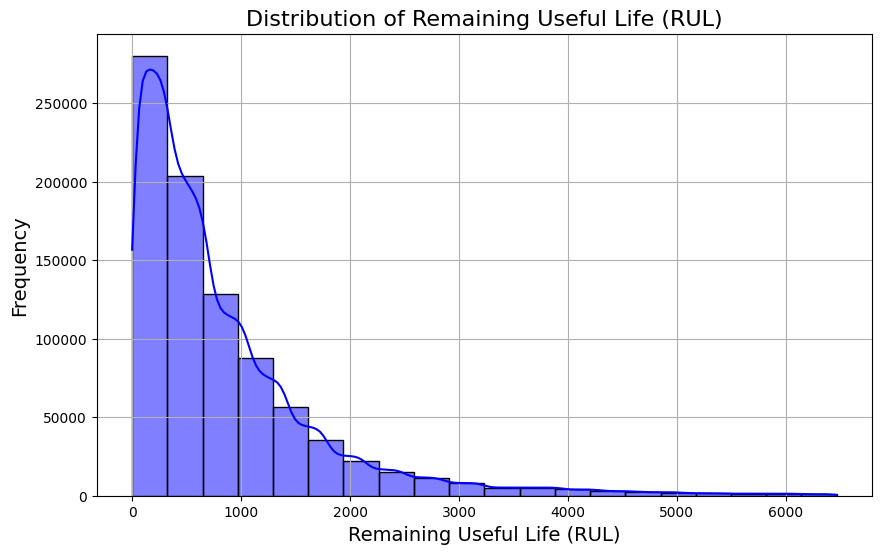

In [204]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['RUL'], bins=20, kde=True, color='blue')
plt.title('Distribution of Remaining Useful Life (RUL)', fontsize=16)
plt.xlabel('Remaining Useful Life (RUL)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

- Presence of Imputed RUL Values: The sharp peak around the mean RUL indicates that many machines or components have missing failure information, leading to a concentration of imputed values.
This can skew model training because the imputed RUL values do not represent real failure patterns and could distort model predictions.

- Right-Skewed Distribution: The right-skewed nature of the distribution suggests that most components/machines have a relatively low RUL, with fewer instances of very high RUL values. This is typical in real-world predictive maintenance data, as machines are more likely to be closer to failure than far away from it.

#### Feature Reduction

                       Feature  Importance
0                    machineID    0.201307
13       time_since_last_maint    0.197738
14       time_since_last_error    0.180382
8                          age    0.155762
12                      model4    0.054023
16  vibration_rolling_mean_12h    0.053913
15    pressure_rolling_mean_6h    0.038764
11                      model3    0.028160
2                       rotate    0.021194
1                         volt    0.018605
4                    vibration    0.015764
3                     pressure    0.015554
5                 failure_flag    0.007510
10                      model2    0.004094
9                       model1    0.003968
17                anomaly_flag    0.001516
7                   maint_flag    0.000928
6                   error_flag    0.000816


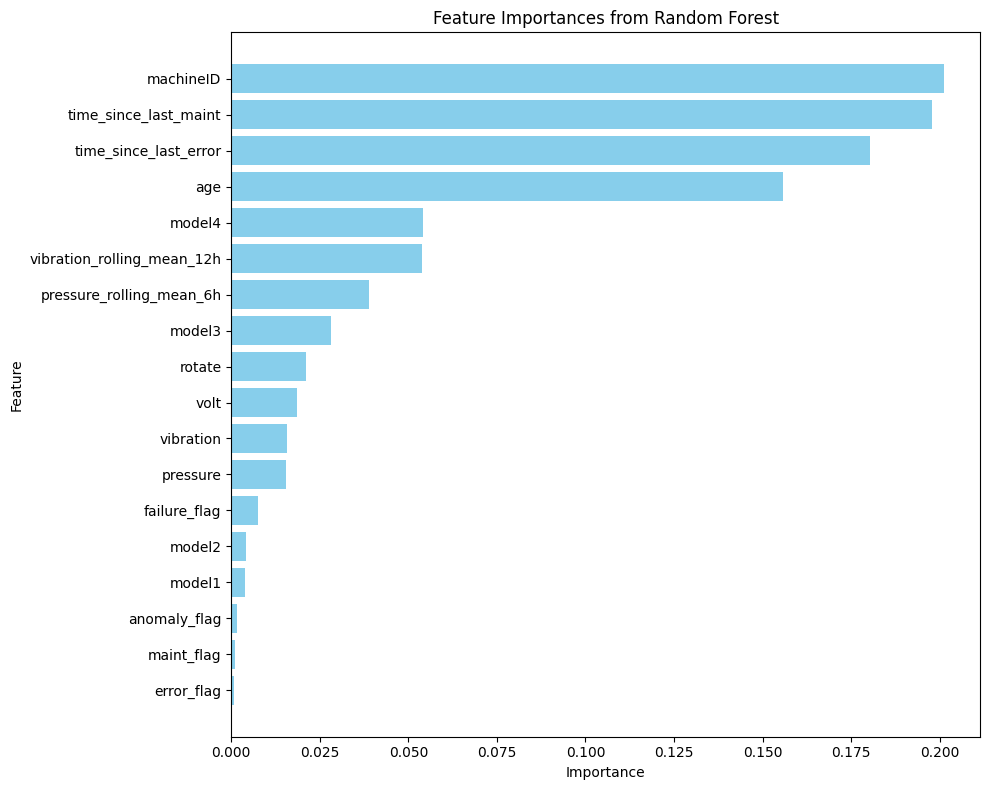

In [205]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
merged_df = merged_df.sort_values(by=['machineID', 'datetime_telemetry'])

target = 'RUL'
features = merged_df.drop(columns=['datetime_telemetry', 'datetime_failure', 'datetime_error', 'datetime_maint', target]).columns.tolist()

train_data = merged_df[(merged_df['datetime_telemetry'] >= '2015-01-01') &
                       (merged_df['datetime_telemetry'] <= '2015-08-31')]
val_data = merged_df[(merged_df['datetime_telemetry'] >= '2015-09-01') &
                     (merged_df['datetime_telemetry'] <= '2015-10-31')]
test_data = merged_df[(merged_df['datetime_telemetry'] >= '2015-11-01') &
                      (merged_df['datetime_telemetry'] <= '2016-01-01')]

X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

rf = RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [206]:
feature_importance_df['Feature'].to_list()

['machineID',
 'time_since_last_maint',
 'time_since_last_error',
 'age',
 'model4',
 'vibration_rolling_mean_12h',
 'pressure_rolling_mean_6h',
 'model3',
 'rotate',
 'volt',
 'vibration',
 'pressure',
 'failure_flag',
 'model2',
 'model1',
 'anomaly_flag',
 'maint_flag',
 'error_flag']

Selected features contributing to 99% of total importance: ['machineID', 'time_since_last_maint', 'time_since_last_error', 'age', 'model4', 'vibration_rolling_mean_12h', 'pressure_rolling_mean_6h', 'model3', 'rotate', 'volt', 'vibration', 'pressure', 'failure_flag']
13


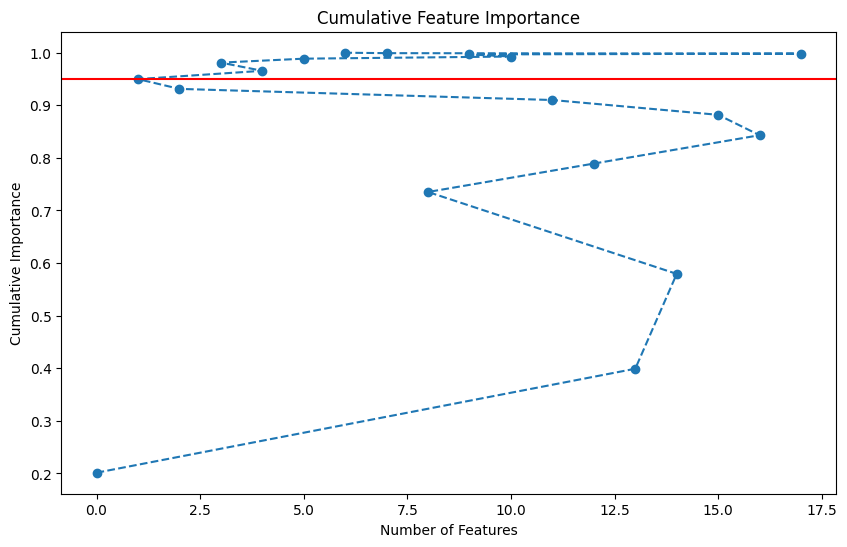

In [207]:
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()
selected_features = feature_importance_df[feature_importance_df['Cumulative Importance'] <= 0.99]['Feature'].tolist()
print(f"Selected features contributing to 99% of total importance: {selected_features}")

print(len(selected_features))
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(feature_importance_df['Cumulative Importance'], marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.show()


#### Model Preparation

In [212]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import numpy as np

merged_df = merged_df.sort_values(by=['machineID', 'datetime_telemetry'])

train_data = merged_df[(merged_df['datetime_telemetry'] >= '2015-01-01') &
                       (merged_df['datetime_telemetry'] <= '2015-08-31')]
val_data = merged_df[(merged_df['datetime_telemetry'] >= '2015-09-01') &
                     (merged_df['datetime_telemetry'] <= '2015-10-31')]
test_data = merged_df[(merged_df['datetime_telemetry'] >= '2015-11-01') &
                      (merged_df['datetime_telemetry'] <= '2016-01-01')]

selected_features = feature_importance_df[feature_importance_df['Cumulative Importance'] <= 0.99]['Feature'].tolist()
selected_features = selected_features + ['maint_flag', 'error_flag']

# Prep X and y Datasets
X_train = train_data[selected_features]
X_val = val_data[selected_features]
X_test = test_data[selected_features]

y_train_log = np.log1p(train_data[['RUL']].values)
y_val_log = np.log1p(val_data[['RUL']].values)
y_test_log = np.log1p(test_data[['RUL']].values)

boolean_columns = ['failure_flag', 'maint_flag', 'error_flag', 'model3', 'model4']
X_train[boolean_columns] = X_train[boolean_columns].astype(int)
X_val[boolean_columns] = X_val[boolean_columns].astype(int)
X_test[boolean_columns] = X_test[boolean_columns].astype(int)

# Scale Selected Columns
scale_columns = ['time_since_last_maint', 'time_since_last_error', 'vibration_rolling_mean_12h', 'pressure_rolling_mean_6h', 'rotate', 'pressure', 'vibration', 'volt']
scaler = MinMaxScaler()

X_train[scale_columns] = scaler.fit_transform(X_train[scale_columns])
X_val[scale_columns] = scaler.transform(X_val[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values

print(X_train_np.shape, y_train.shape)
print(X_val_np.shape, y_val.shape)
print(X_test_np.shape, y_test.shape)


(580300, 15) (580300, 1)
(144100, 15) (144100, 1)
(146500, 15) (146500, 1)


In [213]:
# Check that scaled columns are in the [0, 1] range
print("Checking scaled columns:")
for col in scale_columns:
    min_val = X_train[col].min()
    max_val = X_train[col].max()
    print(f"{col}: min = {min_val}, max = {max_val} (Expected: 0 <= min, max <= 1)")

print("\nChecking unscaled columns:")
print(X_train[['machineID', 'age'] + boolean_columns].head())

print("\nColumn order in X_train:")
print(X_train.columns.tolist())

print("\nFirst few rows of X_train_np:")
print(X_train_np[:5])

Checking scaled columns:
time_since_last_maint: min = 0.0, max = 0.9999999999999999 (Expected: 0 <= min, max <= 1)
time_since_last_error: min = 0.0, max = 1.0 (Expected: 0 <= min, max <= 1)
vibration_rolling_mean_12h: min = 0.0, max = 1.0 (Expected: 0 <= min, max <= 1)
pressure_rolling_mean_6h: min = 0.0, max = 1.0 (Expected: 0 <= min, max <= 1)
rotate: min = 0.0, max = 1.0 (Expected: 0 <= min, max <= 1)
pressure: min = 0.0, max = 1.0 (Expected: 0 <= min, max <= 1)
vibration: min = 0.0, max = 0.9999999999999998 (Expected: 0 <= min, max <= 1)
volt: min = 0.0, max = 0.9999999999999999 (Expected: 0 <= min, max <= 1)

Checking unscaled columns:
     machineID  age  failure_flag  maint_flag  error_flag  model3  model4
0            1   18             0           0           0       1       0
168          1   18             0           0           0       1       0
241          1   18             0           0           0       1       0
398          1   18             0           0          

In [214]:
def create_sequences(features, targets, sequence_length):
    """
    Create sequences of features and corresponding regression targets for time series prediction.

    Parameters:
    - features: numpy array of shape (num_samples, num_features), input features.
    - regression_targets: numpy array of shape (num_samples, num_targets), target for regression (e.g., RUL).
    - sequence_length: int, the length of the sequences to create.

    Returns:
    - X: numpy array of shape (num_sequences, sequence_length, num_features), input sequences.
    - y: numpy array of shape (num_sequences, num_targets), targets for the last time step of each sequence.
    """
    X = np.array([features[i:i + sequence_length] for i in range(len(features) - sequence_length)])
    y = np.array([targets[i + sequence_length] for i in range(len(features) - sequence_length)])
    return X, y

sequence_length = 36

X_train_seq, y_train_seq = create_sequences(X_train_np, y_train_log, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_np, y_val_log, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_np, y_test_log, sequence_length)

X_train_seq = np.array(X_train_seq).astype('float32')
y_train_seq = np.array(y_train_seq).astype('float32')
X_val_seq = np.array(X_val_seq).astype('float32')
y_val_seq = np.array(y_val_seq).astype('float32')
X_test_seq = np.array(X_test_seq).astype('float32')
y_test_seq = np.array(y_test_seq).astype('float32')

print("X_train_seq shape:", X_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("y_val_seq shape:", y_val_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

print("X_train_seq dtype:", X_train_seq.dtype)
print("X_val_seq dtype:", X_val_seq.dtype)
print("X_test_seq dtype:", X_test_seq.dtype)
print("y_train_seq dtype:", y_train_seq.dtype)
print("y_val_seq dtype:", y_val_seq.dtype)
print("y_test_seq dtype:", y_test_seq.dtype)

print("NaNs in X_test_seq:", np.isnan(X_test_seq).sum())
print("NaNs in y_test_seq:", np.isnan(y_test_seq).sum())

np.save('C:/Users/rshaw/Desktop/EC Utbildning - Data Science/Kurs 9 - Project/Project/ds23_projektkurs/predictive-maintenance/notebooks/Robs_preloaded_lstm_model_X_test_seq.npy', X_test_seq)
np.save('C:/Users/rshaw/Desktop/EC Utbildning - Data Science/Kurs 9 - Project/Project/ds23_projektkurs/predictive-maintenance/notebooks/Robs_preloaded_lstm_model_y_test_seq.npy', y_test_seq)

X_train_seq shape: (580264, 36, 15)
X_val_seq shape: (144064, 36, 15)
X_test_seq shape: (146464, 36, 15)
y_train_seq shape: (580264, 1)
y_val_seq shape: (144064, 1)
y_test_seq shape: (146464, 1)
X_train_seq dtype: float32
X_val_seq dtype: float32
X_test_seq dtype: float32
y_train_seq dtype: float32
y_val_seq dtype: float32
y_test_seq dtype: float32
NaNs in X_test_seq: 0
NaNs in y_test_seq: 0


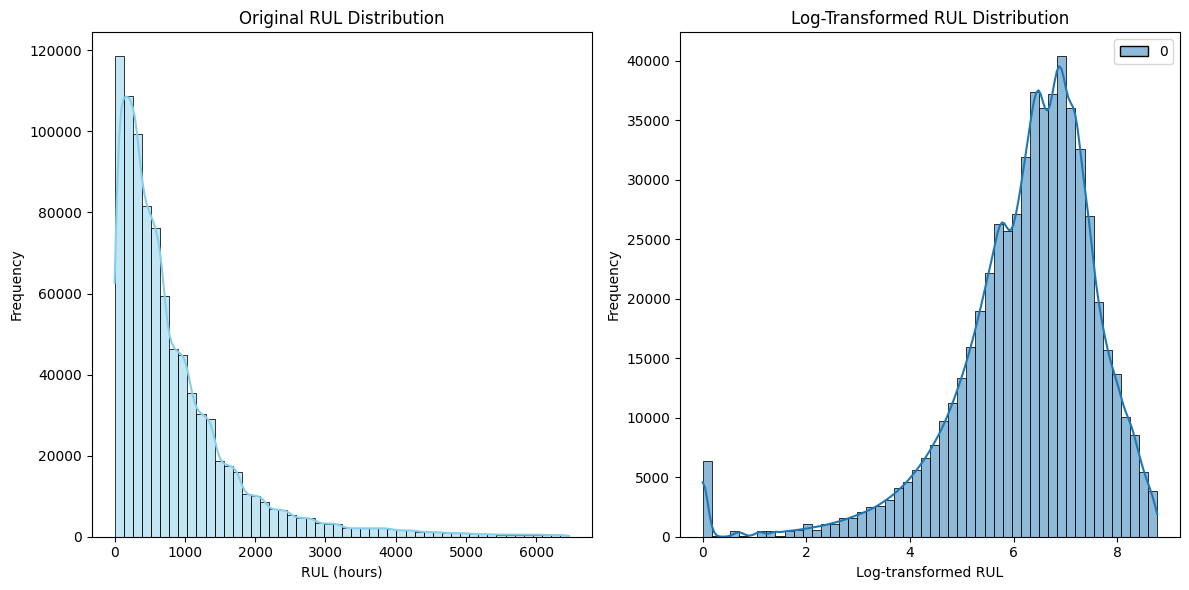

In [215]:
# Original RUL vs. Log-Transformed RUL Distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(merged_df['RUL'], bins=50, kde=True, color='skyblue')
plt.title("Original RUL Distribution")
plt.xlabel("RUL (hours)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(y_train_log, bins=50, kde=True, color='lightcoral')
plt.title("Log-Transformed RUL Distribution")
plt.xlabel("Log-transformed RUL")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#### Model Build: Model Architecture and Compile

In [216]:
import logging
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

logging.basicConfig(filename='model_build.log', level=logging.INFO)
logger = logging.getLogger()

logger.info("Model build underway")

input_shape = (sequence_length, 15)
inputs = Input(shape=input_shape)

x = Bidirectional(LSTM(units=96, return_sequences=True, activation='tanh',
                       kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.001)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh',
                       kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = LSTM(units=50, activation='tanh', return_sequences=False, kernel_initializer=HeNormal())(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Dense layers for RUL prediction
x = Dense(64, activation='relu')(x)

output_rul = Dense(1, activation='linear', name='regression_output_rul')(x)

model = Model(inputs=inputs, outputs=[output_rul])

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss= Huber(),
              metrics=['mean_absolute_error'])

model.summary()

Model: "functional_563"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_563 (InputLayer)         │ (None, 36, 15)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1106 (Bidirectional)   │ (None, 36, 192)             │          86,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1686             │ (None, 36, 192)             │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1686 (Dropout)               │ (None, 36, 192)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1107 (Bidirectional)   │ (None, 36, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1687             │ (None, 36, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1687 (Dropout)               │ (None, 36, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1688 (LSTM)                     │ (None, 50)                  │          35,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1688             │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1688 (Dropout)               │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_563 (Dense)                    │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ regression_output_rul (Dense)        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,209 (1008.63 KB)

 Trainable params: 257,469 (1005.74 KB)

 Non-trainable params: 740 (2.89 KB)

#### Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import logging
import os
from datetime import datetime

logging.basicConfig(filename='training_log.log', level=logging.INFO)
logger = logging.getLogger()
logger.info("Model training started")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

import os
from tensorflow.keras.callbacks import ModelCheckpoint

model_path = 'C:/Users/rshaw/Desktop/EC Utbildning - Data Science/Kurs 9 - Project/Project/ds23_projektkurs/predictive-maintenance/models'
os.makedirs(model_path, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = os.path.join(model_path, f'model_{timestamp}_lstm.keras')

checkpoint = ModelCheckpoint(
    filepath=model_save_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

logger.info("Model training completed")

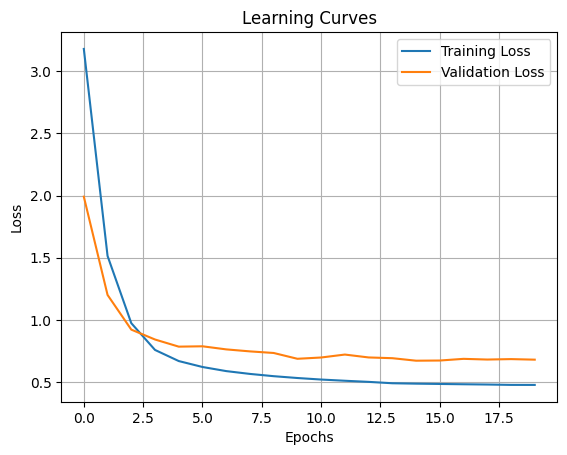

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 36, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 36, 192)        │        86,016 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 36, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 36, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 36, 128)        │       131,584 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 36, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 36, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_output_rul (Dense)   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773,149 (2.95 MB)

 Trainable params: 257,469 (1005.74 KB)

 Non-trainable params: 740 (2.89 KB)

 Optimizer params: 514,940 (1.96 MB)

In [10]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

base_dir = 'C:/Users/rshaw/Desktop/EC Utbildning - Data Science/Kurs 9 - Project/Project/ds23_projektkurs/predictive-maintenance/notebooks/Robs_preloaded_lstm_model'

model = load_model(f'{base_dir}/model_20241027_212326_lstm.keras')

with open(f'{base_dir}/history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

X_test_seq = np.load(f'{base_dir}/X_test_seq.npy')
y_test_seq = np.load(f'{base_dir}/y_test_seq.npy')

plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

model.summary()

##### Model Evaluation

4577/4577 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step
Test MAE: 538.540283203125
     Actual RUL  Predicted RUL
100  949.999878     975.310303
101  949.000000     973.782654
102  947.999878     972.766174
103  946.999878     972.714172
104  946.000061     974.601562
105  944.999878     972.713257
106  943.999939     970.708618
107  943.000122     967.883545
108  942.000000     965.245422
109  941.000000     965.520081
110  939.999756     963.342102
111  939.000122     964.718445
112  937.999817     959.752014
113  937.000061     960.605408
114  936.000061     956.800293
115  935.000183     956.364197
116  934.000061     955.778687
117  933.000122     950.617249
118  931.999939     949.276855
119  930.999939     950.507874
120  930.000061     953.587646
121  929.000000     948.880859
122  928.000061     947.826111
123  926.999939     951.264526
124  925.999939     946.978638
125  925.000183     943.217529
126  924.000183     941.986023
127  922.999939     939.562378
128  921.999878     937.11993

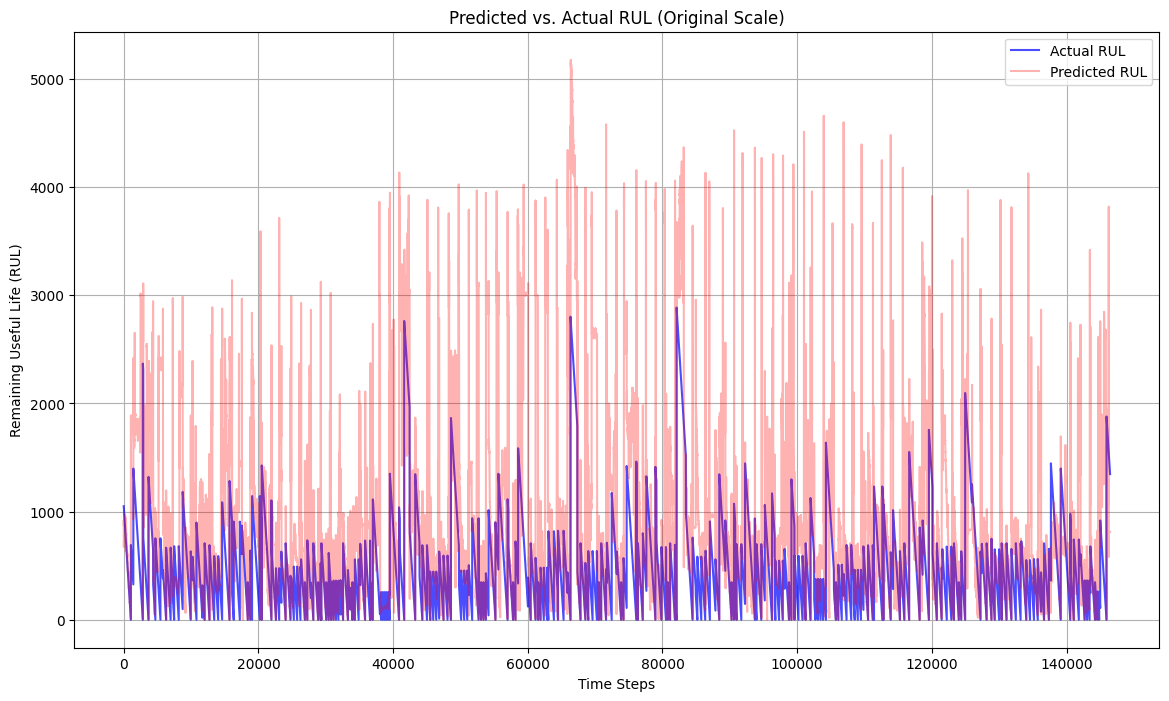

In [6]:
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

logging.basicConfig(filename='evaluation_log.log', level=logging.INFO)
logger = logging.getLogger()
logger.info("Model evaluation started")

# Get predictions
y_pred_log = model.predict(X_test_seq)
y_pred = np.expm1(y_pred_log.reshape(-1, 1))
y_true = np.expm1(y_test_seq.reshape(-1, 1))

test_mae = mean_absolute_error(y_true, y_pred)
print(f"Test MAE: {test_mae}")
logger.info(f"Test MAE calculated: {test_mae}")

# DataFrame for RUL comparison
rul_comparison_df = pd.DataFrame({
    'Actual RUL': y_true.flatten(),
    'Predicted RUL': y_pred.flatten()
})

print(rul_comparison_df[100:150])
logger.info("RUL comparison DataFrame created")

plt.figure(figsize=(14, 8))
plt.plot(y_true, label='Actual RUL', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted RUL', color='red', alpha=0.3)
plt.xlabel('Time Steps')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.title('Predicted vs. Actual RUL (Original Scale)')
plt.grid(True)
plt.show()

logger.info("Model evaluation completed and visualization created")


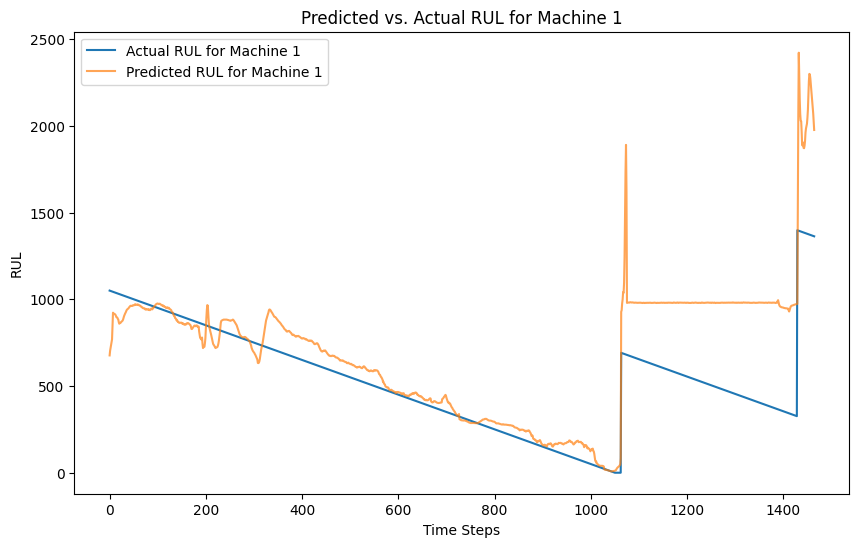

In [7]:
machine_test_seq = X_test_seq[:, 0, 0]

rul_comparison_df = pd.DataFrame({
    'machineID': machine_test_seq,
    'Actual RUL': np.expm1(y_test_seq).flatten(),
    'Predicted RUL': np.expm1(y_pred_log).flatten()
})

machine_pred_actual_df = rul_comparison_df[rul_comparison_df['machineID'] == 1]

# Plot Actual vs Predicted RUL for machineID 1
plt.figure(figsize=(10, 6))
plt.plot(machine_pred_actual_df['Actual RUL'].values, label='Actual RUL for Machine 1')
plt.plot(machine_pred_actual_df['Predicted RUL'].values, label='Predicted RUL for Machine 1', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('RUL')
plt.legend()
plt.title('Predicted vs. Actual RUL for Machine 1')
plt.show()


In [ ]:
# logging.basicConfig(filename='evaluation_log.log', level=logging.INFO)
# logger = logging.getLogger()
# logger.info("Model evaluation started")

# # Load the sequences from the ML models folder
# # X_test_seq = np.load('/content/drive/MyDrive/ML models/X_test_seq.npy')
# # y_test_seq = np.load('/content/drive/MyDrive/ML models/y_test_seq.npy')

# # Get predictions
# y_pred_log = model.predict(X_test_seq)
# #y_pred_log = loaded_model.predict(X_test_seq)

# y_pred = np.expm1(y_pred_log.reshape(-1, 1))
# y_true = np.expm1(y_test_seq.reshape(-1, 1))

# # Calculate evaluation metrics
# test_mae = mean_absolute_error(y_true, y_pred)
# print(f"Test MAE: {test_mae}")
# logger.info(f"Test calculated and logged")

# rul_comparison_df = pd.DataFrame({
#     'Actual RUL': y_true.flatten(),
#     'Predicted RUL': y_pred.flatten()
# })

# print(rul_comparison_df[100:150])
# logger.info("RUL comparison DataFrame created")

# plt.figure(figsize=(14, 8))
# plt.plot(y_true, label='Actual RUL', color='blue', alpha=0.7)
# plt.plot(y_pred, label='Predicted RUL', color='red', alpha=0.3)
# plt.xlabel('Time Steps')
# plt.ylabel('Remaining Useful Life (RUL)')
# plt.legend()
# plt.title('Predicted vs. Actual RUL (Original Scale)')
# plt.show()

# logger.info("Model evaluation completed and visualization created")

In [ ]:
# import logging
# import tensorflow as tf
# from tensorflow.keras import Input, Model
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.initializers import HeNormal
# from tensorflow.keras.losses import Huber
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# from scikeras.wrappers import KerasRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from tensorflow.keras.callbacks import EarlyStopping

# logging.basicConfig(filename='model_build.log', level=logging.INFO)
# logger = logging.getLogger()

# def create_simple_model(sequence_length, learning_rate=0.001, dropout1=0.35, units1=96, units2=64):
#     input_shape = (sequence_length, 15)
#     inputs = Input(shape=input_shape)

#     x = LSTM(units=units1, return_sequences=True, activation='tanh',
#              kernel_initializer='he_normal', kernel_regularizer=regularizers.L2(0.001))(inputs)
#     x = BatchNormalization()(x)
#     x = Dropout(dropout1)(x)

#     x = LSTM(units=units2, activation='tanh', return_sequences=False, kernel_initializer=HeNormal())(x)
#     x = BatchNormalization()(x)
#     x = Dropout(dropout1)(x)

#     x = Dense(32, activation='relu')(x)
#     output_rul = Dense(1, activation='linear', name='regression_output_rul')(x)

#     model = Model(inputs=inputs, outputs=[output_rul])
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(), metrics=['mean_absolute_error'])

#     return model

In [ ]:
# # Reduced parameter grid
# param_grid = {
#     'learning_rate': [0.001, 0.0005],
#     'dropout1': [0.3, 0.4],
#     'units1': [96, 128],
#     'units2': [64],
#     'batch_size': [16],
#     'epochs': [10]
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=2,
#     n_iter=3
# )

# # Fit on a smaller subset of data
# X_train_subset = X_train_seq[:int(len(X_train_seq) * 0.1)]
# y_train_subset = y_train_seq[:int(len(y_train_seq) * 0.1)]
# random_search_result = random_search.fit(X_train_subset, y_train_subset, callbacks=[early_stopping])

# print("Best parameters found:", random_search_result.best_params_)
# print("Best score:", random_search_result.best_score_)